# [Introduction]
1. First I really appreciate this initiative, datasets, and all the contributors of them
2. For a resident in one of the epicentres of COVID-19, this data must be heartbreaking but valuable sources to learn from
3. We Kagglers as data scientists may have a sort of duty to confront this crisis more seriously and collaboratively than ever
4. It's better to confess that I have not enough knowledge nor skills on data science to tackle this professionally
5. But I decided to dive as soon as possible after I found this initiative. Because it's a matter and war of timing
6. It'd be an honor if this effort helped any better understand the disease, spread of it, and its impact on us

<a id='table'></a>
# [Table of Contents]
1. [Insights from EDA](#eda_insights)
2. [Lessons from forecasting](#fc_lessons)
3. [EDA: Exploratory Data Analysis](#eda)
    - [Age](#eda_age)
    - [Region](#eda_region)
    - [Sex](#eda_sex)
    - [Test](#eda_test)
    - [Path](#eda_path)
    - [Weather](#eda_weather)
    - [Patient](#eda_patient)
    - [Activity](#eda_activity)
    - [Seoul](#eda_seoul)
    - [Search](#eda_search)
    - [Policy](#eda_policy)
4. [FC: Forecasting](#fc)
    - [LR / Naive / Average](#fc_basics)
    - ARIMA
        - [Basics](#fc_arima_basics)
    - Prophet
        - [Basics](#fc_prophet_basics)
        - [Space to time](#fc_prophet_fit)
        - [Time to space](#fc_prophet_apply)
5. [Resources](#resources)
6. [Major updates](#updates)
7. [Developing directions](#directions)

<a id='eda_insights'></a>
> # [[Insights from EDA]](#table)

1. [Age](#eda_age)
    - 20s are the most infected age group (27.80% to total)
    - Older than 70 are the most deceased age group (48.08% to total)
    - Countries need to separate the two groups while preventing spreads as a whole
2. [Region](#eda_location)
    - The more populated, the more cases in general (excluding 2 outliers)
    - What's riskier are community-level gatherings like religious events
    - Countries better try to prevent them and detect the particular event if it occured
3. [Sex](#eda_sex)
    - Any significant difference between sexes was not found
    - Females seem more prone to be infected (58.91% VS. 41.09%)
    - Males seem more prone to be deceased (51.92% VS. 48.08%)
4. [Test](#eda_test)
    - The number of tests and negative/released cases have kept increasing linearly
    - Confirmed/deceased cases show more dynamic slope changes than above three while increasing
    - Daily confirmed cases have the second spike around 2020-05-11 (a probable sign of the 2nd wave)
5. [Path](#eda_path)
    - Up to 60% cases seemed to be transmitted by 1 specific gathering (Sinchonji Church in Daegu)
    - The following paths are also from groups like workplaces
    - The imported cases from abroad keep increasing
6. [Weather](#eda_weather)
    - Weather-related features show no clear correlation with infections
    - There is a weak negative correlation between temperature and infections (colder & more infections)
    - There is a weaker positive correlation between maximun wind speed and infections (more wind & more infections)
7. [Patient](#eda_patient)
    - Half of the logged patients have <=4 contacts with (or possible infections to) other patients before confirmed
    - There are outliers with more than 1,000 contacts though
    - The average number of contacts by a patient per day has decreased as time went by
8. [Activity](#eda_activity)
    - Half of the documented patients have <=4 activity logs for 2 weeks before confirmed
    - The most visited places are hospitals followed by stores, public transportations and restaurants
    - Countries should apply a lot stricter preventing measures on these places
9. [Seoul](#eda_seoul) (the capital of S.Korea)
    - Floating population shows a positive correlation with the number of infections (more floating & more infections)
    - The activities of older than 60 decreased after the outbreak of COVID-19
    - The absolute number of cases in each subregion is too small (<100) to draw a conclusion from
10. [Search](#eda_search)
    - Searching on pneumonia was prior to that on COVID-19
    - Increase of COVID-19 searches has been ahead of the actual increase of confirmed cases
    - The searching itself and the number of daily new cases have decreased (with a small spike around 2020-05-11)
11. [Policy](#eda_policy)
    - Level 3 (2nd highest) caution on infectious diseases was implemented proactively
    - Policies on immigration have kept updated for more countries while the borders are open
    - Educational measures are yet shifting 'complete closure' > 'online classes' > 'physical classes (some graders)'

<a id='fc_lessons'></a>
> # [[Lessons from forecasting]](#table)

1. [Linear Regression / Naive / Average](#fc_basics)
    - Linear regression(LR) model on search trends could match a general trend of infections
    - Naive forecasting (by 1 last observation) learns the latest change on the fly
    - Moving average forecasting (by 7 latest observations) works better than LR and naive
    - The combined model of linear regression and one of the basic forecasting methods (naive/average) gives the best score
2. [Prophet - basics](#fc_prophet_basics)
    - The data with 1 infection cycle of increase and decrease are not enough to feed Prophet
        - which is mainly for catching repetitive cyclic and/or seasonal patterns with a global trend
    - S.Korea and some countries have only 1 cycle as they are now fighting against the 1st wave of COVID-19
    - The others have less than 1 cycle as their curves are not flattening yet (meaning they are in the earlier phase)
3. [Prophet - space to time](#fc_prophet_fit)
    - We clustered the countries by recent_to_max equation
        - which is the ratio of the latest daily cases to the max daily cases in a country
    - Then used the data of the countries with <0.1 ratio (<10% to max) to make 1 long time series
    - Prophet learned the general cycle of infections with a reasonable accuracy
        - but the scale of predictions was about half of the truth
        - we scaled and amplified them to match the top with 100% and bottom with 0% daily confirmed cases ratio
4. [Prophet - time to space](#fc_prophet_apply)
    - These predictions could give insights to the countries in the earlier phase
        - on how long does it take to quit the 1 cycle of spreading
            - to prepare necessary resources
            - to design a longterm exit plan
            - to make an effort to shorten the expected time to quit

<a id='eda'></a>
# [[EDA: Exploratory Data Analysis]](#table)

Enviroment setting / Get data

In [ ]:
### [Environment setting]
from __future__ import print_function

## 0. Basics
import re
import math
import copy
import random
import datetime, time
from operator import add
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
from IPython.display import YouTubeVideo
# skipping cells with a long runtime, if True
fast = False
# runtime checker
start_log = datetime.now()

## 1. Data Science
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from matplotlib import pyplot as plt
import seaborn as sns
from plotnine import *
from glob import glob
import missingno as msno
import folium
# import plotly.offline as offline
# import plotly.graph_objs as go

## 2. Statistics
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from scipy import stats

## 3. Forecasting
from pandas.plotting import autocorrelation_plot as acplot
from statsmodels.tsa.arima.model import ARIMA
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

## 4. Machine Learning
import sklearn
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, r2_score

## 5. Plots & Fonts
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.figsize'] = (13, 7)
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams.update({'font.size': 13})
color_list = ['#8DD3C7', '#FEFFB3', '#BFBBD9'
              , '#FA8174', '#81B1D2', '#FDB462'
              , '#B3DE69', '#BC82BD', '#CCEBC4']

In [ ]:
### [Functions]

def get_data(path, transpose=False):
    """
    FUNCTION
        to get and check data from a file path
    @ PARAMS
        path(string) = file path for data
        transpose(bool) = transpose a wide data to show vertically / default=False
    > RETURN
        df_raw = dataframe
    """
    df_raw = pd.read_csv(path)
    print('[Sample data]')
    if transpose:
        display(df_raw.head(3).append(df_raw.tail(3)).T)
    else:
        display(df_raw.head(3).append(df_raw.tail(3)))
    return df_raw

def data_range(data, column, describe=None):
    """
    FUNCTION
        to check date range of time series or scarce chronological data
    @ PARAMS
        data(dataframe) = data to check
        column(string) = column name for date
        describe(string) = additional description on date column
                           e.g. starting_date
    > RETURN
        None
    """
    data_col = pd.to_datetime(data[column]).dt.date
    date_range = (max(data_col) - min(data_col)).days + 1
    if describe==None:
        print(f'Date range: {date_range} days')
    else:
        print(f'Date range ({describe}): {date_range} days')
    print(f'# {min(data_col)} to {max(data_col)}')
    return None


## [Refactor point] handle multiple subplots in 1 figure
def plot_groupby(data, groupby, column, title, ylabel=None, axis=None):
    """
    FUCNTION
        to plot data after grouping by a column
    @ PARAMS
        data = dataframe to plot
        groupby(string) = column name for grouping
        column(string) = column name for y axis
        title(string) = plot title
        axis = specific axis to plot on
    > RETURN
        None
    """
    fig, ax = plt.subplots(figsize=(13, 7))
    plt.title(f'{title}', fontsize=17)
    ax.set_xlabel('Date', size=13)
    if ylabel == None:
        ax.set_ylabel('Number of cases', size=13)
    else:
        ax.set_ylabel(ylabel, size=13)
    group_list = data.groupby(groupby)
    for group in group_list:
        if axis == None:
            plt.plot(group[1].date.values
                     , group[1][column].values
                     , label=group[0])
        else:
            axis.plot(group[1].date.values
                     , group[1][column].values
                     , label=group[0])
        """ Code Performance
        0. Without .values
            - 558 ms ± 23.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
            - 537 ms ± 27.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
            - 587 ms ± 34.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
        1. With .values 
            - 508 ms ± 34.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
            - 515 ms ± 19.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
            - 540 ms ± 19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
        """
    tick_num = 12
    ax.set_xticks(ax.get_xticks()[::int(len(age_raw.date.unique())/tick_num)+1])
    ax.legend()
    plt.show()

    
def split_fit_pred(X, y, model, test_size=0.3, random_state=13, classification=False):
    """
    Function
        to split data into training/test sets, fit a model, and predict with them in one-shot manner
    @params 
        X = independent variables
        y = dependent variable
        model = model to train
        test_size = size of test set / 0<s<1 / default=0.3
        random_state = random seed for stable testing results / default=13
        classification = if classification, split X with stratifying y labels / default=False(linear)
    >return
        model = a fitted model
        prediction = predictions by the model
        train_score = a score by the predictions in training
        test_score = a score by the predictions in test
    """
    # Split
    if classification == True:
        X_train, X_test, y_train, y_test = train_test_split(X, y
                                                            , stratify = y
                                                            , test_size = test_size
                                                            , random_state = random_state)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y
                                                            , test_size = test_size
                                                            , random_state = random_state)
    # Fit & validate
    model.fit(X_train, y_train)
    prediction = model.predict(X_test);
    train_score, test_score = model.score(X_train, y_train), model.score(X_test, y_test)
    return model, prediction, train_score, test_score


def test_with_range(X, y, model, size_range, random_state=13):
    """
    Function
        to test a model with various test set sizes
    @params
        X = independent variables
        y = dependent variable
        model = model to train
        size_range = the range of test sets size to experiment with / 0<s<1
        random_state = random seed for stable testing results / default=13
    @return
        train_list = list of training scores by speicifc value in the given range
        test_list = list of test scores by speicifc value in the given range
        best_test_size = the best size with the best score in test_list
    """
    plt.title(f'Score by Test Set Size (random seed={random_state})', size=17)
    train_list, test_list = list(), list()
    for s in size_range:
        model, prediction, train_score, test_score = split_fit_pred(X, y, model, random_state=random_state, test_size=s)
        train_list.append(train_score); test_list.append(test_score)
    # train_list, test_list
    plt.plot(size_range, train_list)
    plt.plot(size_range, test_list)
    plt.legend(['train_score', 'test_score'])
    plt.xlabel('Test set size')
    plt.ylabel('Score')
    plt.show()
    best_test_size = size_range[np.nanargmax(test_list)]
    print('Best train score: {} (test set size: {})'
          .format(round(np.nanmax(train_list), 2), round(size_range[np.nanargmax(train_list)], 2)))
    print('Best test score: {} (test set size: {})'
          .format(round(np.nanmax(test_list), 2), round(best_test_size, 2)))
    return train_list, test_list, best_test_size


## [Refactor point] need to be merged into test_with_range() as both share a lot except for data type
def test_with_range_ts(X, y, model, size_range, variable):
    """
    Function
        to test a model with various sizes on time series data
    @params 
        X = independent variables
        y = dependent variable
        model = model to train
        size_range = the range of test sets size to experiment with / 0<s<1
        random_state = random seed for stable testing results / default=13
    >return
        train_list = list of training scores by speicifc value in the given range
        test_list = list of test scores by speicifc value in the given range
        best_test_size = the best size with the best score in test_list
    """
    X = np.array(X).reshape(-1, 1)
    train_list, test_list, pred_list = list(), list(), list()
    for i in size_range:
        X_train, X_test, y_train, y_test = X[:-i, :], X[-i:, :], y[:-i], y[-i:]
        model.fit(X_train, y_train)
        train_pred = list(model.predict(X_train))
        test_pred = list(model.predict(X_test))
        train_score = model.score(X_train, y_train)
        test_score = model.score(X_test, y_test)
        train_list.append(train_score)
        test_list.append(test_score)
        pred_list.append(train_pred + test_pred)
    plt.figure(figsize=(13, 7))
    plt.title(f'Score by Test Set Size (%s)'%variable, size=17)
    plt.plot(size_range/len(X), train_list)
    plt.plot(size_range/len(X), test_list)
    plt.legend(['Training score', 'Test score'])
    plt.xlabel('Test set size')
    plt.ylabel('Score')
    plt.show()
    best_score = np.nanmax(test_list)
    best_size = size_range[np.nanargmax(test_list)]
    best_pred = pred_list[np.nanargmax(test_list)]
    print(f'Best training score: %.4f (test set size=%.2f)'%(np.nanmax(train_list)
                                                          , size_range[np.nanargmax(train_list)]/len(X)))
    print(f'Best test score: %.4f (test set size=%.2f)'%(np.nanmax(test_list)
                                                       , best_size/len(X)))
    return train_list, test_list, best_pred, best_score, best_size


def get_recent_to_max(data, group='Country_Region', min_cases=1, recent_window=3):
    """
    FUNCTION 
        to convert raw data with cases by subregion into with that by country
        to add a column measuring which phase of spreading a country is in
            recent_to_max = n latest observation (3 latest, in case the last is 0) 
                            divided by
                            max daily case of a country
    @ PARAMS 
        data = data to convert
        group = criterion for grouping target values
        min_caes = minimum number of cases in a country to be listed
        recent_window = how many observations to apply in recent_to_max calculation
    > RETURN 
        rtm_df = DataFrame with columns of total_cases and recent_to_max (indexed by country)
        data_group = DataFrame grouped by group column
    """
    ## 1. Get source data by country / set dictionary to save total cases and recent_to_max
    data_group = data.groupby(group)
    total_dict, rtm_dict = dict(), dict()
    for i in data_group:
        if i[1].TargetValue.sum() > min_cases:
            total_dict[i[0]] = i[1].TargetValue.sum()
#     ## 2-1. Handle 0 latest cases (for being robust to the exceptional 0 day)
#             if i[1].TargetValue.iloc[-1] == 0 and recent_window ==1:
#                 recent_window = 3
#             else:
#                 recent_window = 1
#             rtm_dict[i[0]] = i[1].TargetValue[-recent_window:].mean() / i[1].TargetValue.max()
    ## 2-2. Handle 0 latest cases (for being robust to the exceptional 0 day)
            if i[1].TargetValue.max() in i[1].TargetValue[-recent_window:].values:
                rtm_dict[i[0]] = 1
            else:
                rtm_dict[i[0]] = i[1].TargetValue[-recent_window:].mean() / i[1].TargetValue.max()
    ## 3. Get the result dataframe
    rtm_df = pd.DataFrame(np.array([list(total_dict.values()), list(rtm_dict.values())]).T
                          , index = total_dict.keys()
                          , columns = ['total_cases', 'recent_to_max'])
#     rtm_df.index.name = 'Country_Region'
    rtm_df = rtm_df.sort_values('total_cases', ascending=False)
    return rtm_df, data_group


def plot_phase(data_grouped, rtm_df, no_of_country=3, trim=False, scale=False, reverse=False):
    """
    FUNCTION 
        to plot the daily confirmed cases for each country
        to check in which phase (early, middle, late) of spreading it is
    @ PARAMS 
        group = list of time series data grouped by a column
        rtm_df = dataframe with total_cases and recent_to_max columns per country
        no_of_country = number of countries to plot
        trim = starts from the day with 1st case (than the given first)
        scale = scale target values to the max in a given period
        reverse = reverse the given order of index
    > RETURN 
        None
    """
    ## 1. Set list of countries to plot
    if reverse:
        country_list = rtm_df.index[-no_of_country:][::-1]
    else:
        country_list = rtm_df.index[0:no_of_country]
    ## 2. Plot daily cases for each country
    for i, j in zip(country_list, np.arange(1, len(country_list)+1)):
        group = data_grouped.get_group(i)
        if trim:
            # starts from the day with 1st case
            first_case_idx = int(group[group.TargetValue > 0].head(1).index.values)
        else:
            first_case_idx = 0
        group = group.loc[first_case_idx:, :] # loc than iloc
        group = group.groupby('Date').sum()
        group = group.loc[ :, ['TargetValue'] ]
        fig, ax = plt.subplots(figsize=(13, 7))
        plt.title('Daily Confirmed Cases - {0}. {1} (total cases={2}, recent to max={3})'
                  .format(j, i
                          , int(rtm_df.loc[i, "total_cases"])
                          , round(rtm_df.loc[i, "recent_to_max"], 4))
                  , size=17)
        if scale:
            group.TargetValue = group.TargetValue / max(group.TargetValue) * 100
        ax.plot(group.index
                , group.TargetValue)
        ax.set_xticks(ax.get_xticks()[::13])
        ax.set_xlabel('Confirmed date')
        ax.set_ylabel('Number of cases', size=13)
    return None
    
    
def arima_grid(truth, p_anchor, d_anchor, q_anchor, window):
    """
    FUNCTION
        to grid search for ARIMA model parameters (p, d, q)
    @ PARAMS
        truth = dataframe saving Date and TargetValue columns
        p_anchor, d_anchor, q_anchor = mid point for list of possible parameters
        window = range of extending anchor values (-/+ window applied to each anchor)
    > RETURN
        param_list = list of parameter sets
        mape_list = list of MAPE per each parameter sets
    """
    p_range = np.arange(max(0, p_anchor-window), p_anchor+window+1)
    d_range = np.arange(max(0, d_anchor-window), d_anchor+window+1)
    q_range = np.arange(max(0, q_anchor-window), q_anchor+window+1)
    param_list, mape_list = list(), list()
    for p in p_range:
        for d in d_range:
            for q in q_range:
                arima = ARIMA(truth.TargetValue
                              , dates=truth.Date
                              , order=(p, d, q)
                              , freq="D").fit()
                arima_pred = arima.predict()
                _, _, _, mape = diff_metrics(truth.TargetValue[:-1], arima_pred[1:])
                param_list.append(f'{p}, {d}, {q}')
                mape_list.append(mape)
    plt.plot(param_list, mape_list)
    plt.title('MAPE by parameter set', size=17)
    plt.xlabel('Parameter set', size=13)
    plt.ylabel('MAPE (Mean Absolute Percentage Error)', size=13)
    plt.xticks(rotation=31)
    plt.show()
    return param_list, mape_list


def do_prophet(data, date_column, y_column
               , benchmark=None, test_size=1
               , is_bench=False, bm_name='best model at present'
               , season_mode='additive', custom_period=False, period=None, num_curve=5
               , simple=True
               ):
    """
    Function 
        to apply Prophet with default parameters
    @Params 
        data = data before being formatted in Prophet manner
        date_column = column name for time steps
        y_column = column name for independent variable
        benchmark = benchmark prediction to plot
        test_size = size for forecasting / 1<s<len(data) / default=1
        is_bench = if is_bench, plot benchmark prediction too / default=True
        bm_name = name (or description) for benchmark method
        sesson_mode = the mode for calculating seasonality / default='additive', optional='multiplicative'
        custom_period = set and use custom period
        period = custom period / format='n days(or other time unit)'
        num_curve = how many curves are allowed / default=5 / the more, the more flexible, prone to overfitting, and time need to fit
        simple = if simple, don't print out intermediate details (only plot the last prediction plot) / default=True
    >return 
        pp = the fitted Prophet model (useful for cross validation)
        predict = the predictions by the model (useful for visualization)
    """
    ## 1. Prepare a dataframe
    forecast_df = data[ [date_column, y_column] ]
    if not simple:
        print('[Raw Data - sample]')
        display(forecast_df.head(3).append(forecast_df.tail(3)))
    forecast_df = data.rename(columns = {date_column: 'ds' # ds: Date Stamp
                                         , y_column: 'y'}) # y: values to forecast
    # forecast_df.ds = pd.to_datetime(forecast_df.ds) # string to datetime
    ## 2. Split
    forecast_train, forecast_test = forecast_df.iloc[:-test_size, :], forecast_df.iloc[-test_size:, :]
    if not simple:
        print(f'Training-set size: %d\nTest-set size: %d\n'%(forecast_train.shape[0], forecast_test.shape[0]))
    ## 3. Fit
    if custom_period:
        pp = Prophet(\
                     seasonality_mode=season_mode
                     , yearly_seasonality=False
                     , weekly_seasonality=False
                     , daily_seasonality=False
                    ).add_seasonality(name='custom'
                                      , period=period
                                      , fourier_order=num_curve)
    else:
        pp = Prophet()
    pp.fit(forecast_train)
    if not simple:
        print('# Prophet model trained\n')
    ## 4. Predict
    frame = pp.make_future_dataframe(periods=test_size)
    predict = pp.predict(frame)
    if not simple:
        print('[Forecasting result - sample]')
        display(predict.tail(3).T)
        print('# yhat = predicted point value')
    ## 5. Plot predictions
    fig, ax = plt.subplots(figsize=(13, 7))
    plt.title('Confirmed Cases Prediction (Prophet)', size=17)
    plt.plot(forecast_df.ds, forecast_df.y
             , color='#33322B', ls=':', lw=3)
    plt.plot(forecast_df.ds, predict.yhat)
    if is_bench:
        plt.plot(forecast_df.ds, benchmark)
    ax.axvline(forecast_df.ds.values[len(forecast_df)-test_size], ls=':', color='crimson')
    ax.set_xticks(ax.get_xticks()[::12])
    if is_bench:
        ax.legend(['Truth'
                   , 'Prediction (Prophet)'
                   , f'Benchmark (%s)'%bm_name
                   , 'Test starts']
                  , fontsize=11
                  , loc='upper left'
                 )
    else:
        ax.legend(['Truth'
                   , 'Prediction (Prophet)'
                   , 'Test starts']
                  , fontsize=11
                  , loc='upper left'
                 )
    plt.xlabel('Confirmed date', size=13)
    plt.ylabel('Number of cases', size=13)
    plt.show()
    return pp, predict


## [Refactor point] need to embrace multi-steps forecasting
def result_df(date, truth, pred):
    """
    FUNCTION 
        to make a dataframe for test results for one-step forecasting
    @ PARAMS 
        date(string) = column name for date
        truth(numeric) = truth value
        pred(numeric) = predicted value
    > RETURN 
        result = result dataframe with 'truth, prediction, difference(truth-prediction)' as columns
    """
    col = ['truth', 'prediction', 'difference']
    result = pd.DataFrame(columns=[col], index=[date])
    result.loc[date, 'truth'] = truth
    result.loc[date, 'prediction'] = pred
    result.loc[date, 'difference'] = truth-pred
    return result


def diff_metrics(truth, pred):
    """
    FUNCTION
        to calculate difference (predictions-truth) and the performance metrics
    @ PARAMS
        truth(sequences of numeric values) = truth values
        pred(sequences of numeric values) = predicted values
    > RETURN
        diff = pred - truth
        rmse = Root Mean Sqaure Error
        mae = Mean Absolute Error
        mape = Mean Absolute Percentage Error
    """
    diff = np.array(pred) - np.array(truth)
    rmse = np.sqrt(np.mean(diff**2))
    mae = np.mean(np.abs(diff))
    mape = np.mean(np.abs(diff) / (np.array(truth) + 1))
    return diff, rmse, mae, mape


def perform_report(truth, pred):
    """
    FUNCTION
        to get performance report as dataframes (dependent on diff_metrics())
    @ PARAMS
        truth(sequences of numeric values) = truth values
        pred(sequences of numeric values) = predicted values
    > RETURN
        result = dataframe with columns of 'truth, prediction, difference'
        metrics = dataframe with columns of 'rmse, mae, mape'
    """
    diff, rmse, mae, mape = diff_metrics(truth, pred)
    result = pd.DataFrame(
        {'truth': truth
         , 'prediction': pred
         , 'difference': diff}
    )
    metrics = pd.DataFrame(
        {'rmse': rmse
         , 'mae': mae
         , 'mape': mape}
        , index=['score']
    )
    display(result)
    display(metrics)
    return result, metrics


def set_style():
    """
    FUNCTION
        to set color theme with a custom dark, plus additional style settings like figsize
    @ PARAMS
        None
    > RETURN
        None
    """
    plt.style.use('seaborn')
    plt.figure(figsize=(13, 1.3))
    plt.title('Plot Style Set - seaborn')
    plt.plot(np.linspace(np.pi, np.pi**np.pi))
    plt.show()
    plt.style.use('dark_background')
    plt.rcParams['axes.grid.axis'] = 'y'
    plt.rcParams['grid.linestyle'] = ':'
    plt.rcParams['grid.color'] = '#33322B'
    plt.rcParams['figure.autolayout'] = True
    plt.rcParams['figure.figsize'] = (13, 7)
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams.update({'font.size': 13})
    plt.figure(figsize=(13, 1.3))
    plt.title('Plot Style Set - dark, again')
    plt.plot(np.linspace(np.pi, np.pi**np.pi))
    plt.show()
    
set_style()

In [ ]:
## Get data
import os
last_update = '2020-06-01'
print(f'[Dataset list]\n# updated on %s'%last_update)
file_paths_raw = []
for dirname, _, filenames in os.walk('./Dataset/'):
    for filename in filenames:
        file_paths_raw.append(os.path.join(dirname, filename))
file_names = ['TimeAge.csv', 'TimeProvince.csv', 'Region.csv', 'TimeGender.csv'
              , 'Time.csv', 'Case.csv', 'Weather.csv', 'PatientInfo.csv'
              , 'PatientRoute.csv', 'SeoulFloating.csv', 'SearchTrend.csv', 'Policy.csv']
file_paths = [ j for i in file_names for j in file_paths_raw if i in j ]
file_paths

About the datasets
    1. TimeAge - time series data on the patients by age
    2. TimeProvince - time series data by administrative region
    3. Region - metadata on each region
    4. TimeGender - time series data on the patients by sex
    5. Time - time series data on the tests and the results
    6. Case - data on infection cases (path of transmission)
    7. Weather - time series data on the weather in each region
    8. PatientInfo - sparse data on the profiles of some confirmed patients
    9. PatientRoute - saprse data on the patients' activities before being confirmed
    10. SeoulFloating - time series data on the floating population in Seoul
    11. SearchTrend - time series data on the search keywords related to COVID-19 and other respiratory diseases
    12. Policy - sparse data on the policies implemented by S.Korean government on COVID-19
- more detailed description by the data uploader - [[DS4C] What is this dataset](https://www.kaggle.com/kimjihoo/ds4c-what-is-this-dataset-detailed-description)

At first glance
    1. The most surprising factor is the age distribution of patients
    2. Because there are much more young patients (especially 20s) than the elders 
        - it could be counterintuitive to some media-consumers' prespectives
    3. So let's face with TimeAge data first

<a id='eda_age'></a>
> # [[EDA]](#table) 1. Age

In [ ]:
## 1. Get / Check data
age_raw = get_data(file_paths[0])
data_range(age_raw, 'date')
age_list = age_raw.age.unique()
print('Age groups:', age_list)
print('# 80s == 80s and older')

## 2. Plot cases by age
fig, ax = plt.subplots(figsize=(13, 7))
plt.title(f'Confirmed Cases by Age ({last_update})', fontsize=17)
sns.barplot(age_list, age_raw.confirmed[-9:])
ax.set_xlabel('age', size=13)
ax.set_ylabel('number of cases', size=13)
plt.show()

Probable Reasons - for the exceptionally many confirmed cases in 20s
    1. Social Factors
        - 20s tend to have more social activities than the others
           - e.g. universities, datings, and hanging out
        - When it comes to 10s, all schools have been on vacation and the beginning of new semesters delayed
            - unlike these schools, universities have not just classrooms but also research institutes which keep running
    2. Romantic Factors
        - 20s are the peak of romantic seasons biologically
    3. Psychological Factors
        - We heard from media that COVID-19 is critically dangerous to the elders
        - COVID-19 might seem "just" another type of flu or cold for some youngers
        - This could make them take containing efforts (like quarantine and social distancing) less seriously
What about the relative size of confirmed cases to the population of each group? (than absolute numbers like above)

Population Distribution in South Korea (as of 2020)
- reference: [KOSIS - Korean Statistical Information Service](http://kosis.kr/visual/populationKorea/experienceYard/populationPyramid.do?mb=N&menuId=M_3_2)

In [ ]:
## 1. Get population distribution table
pop_order = pd.DataFrame()
pop_order['age'] = age_list
pop_order['population'] = (4055740, 4732100, 6971785, 7203550, 8291728, 8587047, 6472987, 3591533, 1874109)
pop_order['proportion'] = round(pop_order['population']/sum(pop_order['population']) * 100, 2)
pop_order = pop_order.sort_values('population', ascending=False)
pop_order.set_index(np.arange(1, 10), inplace=True)
display(pop_order)

## 2. Plot population distribution
    # code source for donut chart: https://python-graph-gallery.com/162-change-background-of-donut-plot/
color_pie = [color_list[5], color_list[4], color_list[3]
             , color_list[2], color_list[6], color_list[1]
             , color_list[0], color_list[7], color_list[8]]
fig, ax = plt.subplots(figsize=(11, 11))
plt.title('Population Distribution (2020)', fontsize=17)
pop_circle = plt.Circle((0,0), 0.79, color='black')
plt.pie(pop_order.proportion
        , labels = pop_order.age
        , autopct = '%.2f%%'
        , colors = color_pie
        , startangle=90
        , counterclock=False)
p=plt.gcf()
p.gca().add_artist(pop_circle)
plt.show()

Confirmed cases regarding population distribution by age

In [ ]:
## 1. Get a new table with population / proportion by age
confirmed_by_population = pop_order.sort_values('age')
confirmed_by_population['confirmed'] = list(age_raw[-9:].confirmed)

## 2. Get confirmed ratio regarding population
confirmed_by_population['confirmed_rate'] = confirmed_by_population['confirmed']/confirmed_by_population['population'] * 100;
display(confirmed_by_population)

## 3. Plot confirmed rate by age
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Population-adjusted Confirmed Rate by Age', fontsize=17)
ax.bar(age_list, confirmed_by_population.confirmed_rate[-9:], color=color_list)
ax.set_xlabel('Age', size=13)
ax.set_ylabel('Confirmed rate (%)', size=13)
plt.show()

Compare two graphs

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(23, 7))

## 1. Absolute numbers
axes[0].set_title('Confirmed Cases by Age', fontsize=15)
axes[0].bar(age_list, confirmed_by_population.confirmed, color=color_list)

## 2. Confirmed rate
axes[1].set_title('Population-adjusted Confirmed Rate', fontsize=15)
axes[1].bar(age_list, confirmed_by_population.confirmed_rate, color=color_list)

plt.show()

Snap Analysis - population based confirmed rate
    1. The older, the more prone to get infected in general
    2. 50s's big portion shrinks because they are the largest age group
    3. 20s are the outlier as they are midsize but the most infected group

Time series of cumulative cases by age

In [ ]:
## Plot time series of confirmed cases
plot_groupby(age_raw, 'age', 'confirmed', 'Confirmed Cases by Age (cumulative)')

Snap Analysis - confirmed cases by time
    1. The gap between 20s and the other age groups kept wider up to 2020-03-08
    2. After then the slope of all groups are getting smoother
        - But that of 80s began steeper again around 2020-03-18
        - 20s' cases increased more than others (starting 2020-03-23 and 2020-05-07)
    3. As of 2020-06-02 10s ~ 50s show upward curve while the curves of over 60 are almost flattened

In [ ]:
## 1. Plot time series of deceased cases
plot_groupby(age_raw, 'age', 'deceased', 'Deceased Cases by Age (cumulative)')

## 2. Check absolute numbers
age_deceased = age_raw.tail(9)[['age', 'deceased']]
age_deceased.set_index(np.arange(0, len(age_raw.age.unique())), inplace=True)
print('[Latest deceased cases]')
display(age_deceased.T)

Snap Analysis - deceased cases by time
    1. Clearly different than confirmed, 80s and 70s are at the highest places
    2. 20s have 0 deceased cases even though there are around 3000 infections among them
    3. Almost all ages show flattening curve recently (except for 70s)

In [ ]:
## 1. Add a column for deceased rate 
age_raw['deceased_rate'] = age_raw.deceased/age_raw.confirmed * 100.0

## 2. Plot time series of deceased rate
plot_groupby(age_raw, 'age', 'deceased_rate', 'Deceased Rate by Age (cumulative)', 'Deceased Rate')

Snap Analysis - deceased rate (confirmed case-adjusted)
    1. 80s show more than 2 times higher deceased rate than 70s
    2. 80s' deceased rate decreased at the end of May with more confirmed cases than decaased ones
    3. 70s has around 4 times deceased rate to that of 60s (and far bigger than the younger)

###### Click "output" to compare three graphs side by side

In [ ]:
## Three graphs side by side
if not fast:
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(23, 7))
    sub_list = [age_raw.confirmed, age_raw.deceased, age_raw.deceased_rate]
    title_list = ['Confirmed Cases', 'Deceased Cases', 'Deceased Rate']
    for sub, i, title in zip(sub_list, range(len(sub_list)), title_list):
        confirmed_set = sub.groupby(age_raw.age)
        for confirmed_each, age_each in zip(confirmed_set, age_list):
            axes[i].plot(age_raw.date.unique(), confirmed_each[1], label=age_each)
            axes[i].set_title(title, size=17)
        axes[i].set_xticks(axes[i].get_xticks()[::15])
        axes[i].legend(fontsize=13)

<a id='eda_region'></a>
> # [[EDA]](#table) 2. Region

In [ ]:
# 1071 rows in total: cases in each province on a certain date
region_raw = get_data(file_paths[1])
data_range(region_raw, 'date')

Numbers to check

In [ ]:
# There are 17 provinces (we call it region from now on)
    # as there are cities in the columns too
print('Number of regions:', len(region_raw.province.unique()))
print('Number of logs per region:', len(region_raw[region_raw.province=='Jeju-do']))
print('regions * logs:', len(region_raw.province.unique()) * len(region_raw[region_raw.province=='Jeju-do']))
print('Number of rows:', len(region_raw))

Basic statistics - Total

In [ ]:
region_raw.describe().iloc[1:, 1:]

Confirmed cases distribution by region

In [ ]:
# Get the latest distribution of cumulative confirmed cases
loc_latest = region_raw[region_raw.date==region_raw.date.iloc[-1]]
del loc_latest['date']
del loc_latest['time']
loc_latest = loc_latest.iloc[:, :2]
loc_latest['proportion'] = round(loc_latest.confirmed / sum(loc_latest.confirmed) * 100, 2)
loc_latest = loc_latest.sort_values('proportion', ascending=False)
loc_latest.set_index(np.arange(1, len(loc_latest)+1), inplace=True)
loc_latest_all = loc_latest.copy()
loc_latest_all

In [ ]:
# Put other than the 5 regions with most cases into others
loc_latest.loc['18',:] = loc_latest.iloc[6:, :].sum()
loc_latest.loc['18','province'] = 'Others'
loc_latest = loc_latest[loc_latest.proportion > loc_latest.iloc[5, 2]]
loc_latest

# Distribution Graph
fig, ax = plt.subplots(figsize=(11, 11))
plt.title(f'Confirmed Cases Distribution by Region ({last_update})', fontsize=17)
pop_circle=plt.Circle((0,0), 0.79, color='black')
plt.pie(loc_latest.proportion
        , labels=loc_latest.province
        , autopct='%.2f%%'
#         , explode=(0.03, 0, 0, 0, 0, 0, 0)
        , startangle=90
        , counterclock=False
       )
p=plt.gcf()
p.gca().add_artist(pop_circle)
plt.show()

Snap Analysis - confirmed cases by region
    1. 'Daegu' + 'Gyeongsangbuk-do' have about 75% of all confirmed cases
    2. There was a big religious event in Daegu right before the mass infections
        - which is said to be the origin of most cases in those regions
    3. Other than them, the capital metropolitan area has the most cases (Seoul, Gyunggi-do, Incheon)

#### Confirmed cases by time

In [ ]:
# Total		
total_list = region_raw.groupby('date').sum().confirmed

fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Cumulative Confirmed Cases (total)', fontsize=17)
ax.set_xlabel('Date', size=13)
ax.set_ylabel('Number of cases', size=13)
plt.plot(region_raw.date.unique()
         , region_raw.groupby('date').sum().confirmed)
ax.set_xticks(ax.get_xticks()[::11])
plt.show()

Early phase

In [ ]:
pd.DataFrame(total_list[total_list<=104].tail(3)).T

Explosion

In [ ]:
pd.DataFrame(total_list[total_list>=7900].head(3)).T

Snap Analysis - confirmed cases by time (total)
    1. Lower than 100 cases were for the first 1 month (from the 1st case on 2020-01-20 to 104th on 2020-02-20)
    2. A steep linear growth happened from then for about 3 weeks (with passing 8000 cases on 2020-03-14)
    3. The curve has been flattening up to 2020-05-08 (then began to go upward again)

###### Click "output" to see the plots for all regions

In [ ]:
if not fast:
    print('[Confirmed Cases in each region (most to least)]')

    # region list by order of confirmed cases (based on latest data)
    loc_list = region_raw[region_raw.date==region_raw.date.iloc[-1]]\
               .sort_values('confirmed', ascending = False)\
               .province

    # Get a graph for each region
    for loc_name in loc_list:
        fig, ax = plt.subplots(figsize=(13, 7))
        plt.title(f'Confirmed Cases ({loc_name})', fontsize=17)
        ax.set_xlabel('Date', size=13)
        ax.set_ylabel('Number of cases', size=13)
        loc_raw = region_raw[region_raw.province==loc_name]
        plt.plot(loc_raw.date.unique(), loc_raw.confirmed)
        ax.set_xticks(ax.get_xticks()[::11])
        plt.show()

Without 2 outlier regions having 75% of all cases

In [ ]:
## 1. Without 2 outliers
wo_outliers = region_raw[(region_raw.province!='Daegu') 
                           & (region_raw.province!='Gyeongsangbuk-do')
                          ].groupby('date').sum().confirmed
## 2. Plot cases
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Confirmed Cases (without Daegu, Gyeongsangbuk-do)', fontsize=17)
ax.set_xlabel('Date', size=13)
ax.set_ylabel('Number of cases', size=13)
plt.plot(region_raw.date.unique(), wo_outliers)
ax.set_xticks(ax.get_xticks()[::11])
plt.show()

Compare with 2 outliers and total

In [ ]:
## 1. The regions with 2 most cases
outliers = region_raw[(region_raw.province=='Daegu')\
                        | (region_raw.province=='Gyeongsangbuk-do')
                       ].groupby('date').sum().confirmed
## 2. Compare by plot
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Confirmed cases (total / outliers / without outliers)', fontsize=17)
plt.plot(region_raw.date.unique(), total_list, color=color_list[2])
plt.plot(region_raw.date.unique(), outliers, color=color_list[1])
plt.plot(region_raw.date.unique(), wo_outliers, color=color_list[0])
ax.set_xticks(ax.get_xticks()[::11])
plt.xlabel('Date')
plt.ylabel('Number of cases')
plt.legend(['Total', 'Outliers (Daegu, Gyeongsangbuk-do)', 'Without outliers'])

plt.show()

Snap Analysis
    1. The 1st flattening in the total curve was mainly due to the decrease in the outliers (from 2020-03-08 to 2020-04-06)
    2. The number of cases in the other areas kept linearly increasing up to 2020-04-06
    3. This curve began flattening after then while those of the outliers were flattened more
        - non outliers' curve moved upward from 2020-05-09 again which pushed the total curve upward too 

### Metadata on region

In [ ]:
loc_meta_raw = pd.read_csv(file_paths[2])
print('[Sample data]')
loc_meta_raw.tail(3).T

In [ ]:
print('Number of unique regions:', len(loc_meta_raw.province.unique()))
print(loc_meta_raw.province.unique())

Basic numbers (total)

In [ ]:
loc_meta_raw[loc_meta_raw.province=='Korea'].T

Elderly population proportion by region (without the row for Korea)

In [ ]:
elderly_pop_df = pd.DataFrame(loc_meta_raw[loc_meta_raw.province!='Korea']
                          .groupby('province').mean()
                          .elderly_population_ratio
                          .sort_values(ascending=False)
                         )
elderly_pop_df

In [ ]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Elderly population proportion by region', fontsize=17)
plt.xticks(rotation=31)
plt.bar(elderly_pop_df.index, elderly_pop_df.elderly_population_ratio, color=color_list[1])
plt.xlabel('region')
plt.ylabel('Proportion to total population (%)')
plt.show()

Snap Analysis - elderly popultaion proportion
    1. The more rural a region is, the more elderly are there
        - up to 7th, Gangwon-do, the regions are major rural areas in S.Korea
    2. No speicific region shows an exceptionally high or low composition of the elderly
    3. The epicentre of outbreak, Daegu, is at the 9th place on the list 
        - and not that older than the other cities rightside

In [ ]:
elderly_pop_ordered = elderly_pop_df.loc[loc_latest_all.province.values, :].elderly_population_ratio
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Elderly population proportion (order by confirmed cases - most to least)', fontsize=17)
plt.xticks(rotation=43)
plt.xlabel('Region')
plt.ylabel('Proportion to total population (%)')
plt.bar(elderly_pop_ordered.index, elderly_pop_ordered, color=color_list[1])
plt.show()

Snap Analysis - elderly proportion and confirmed cases
    1. No correlation between elderly population proportion and the number of confirmed cases
    2. Gyeongsangbuk-do is right next to Daegu geographically (check the map below)
        - Daegue: the pink area
        - Gyeongsangbuk-do: the upper-right area (almost including Daegu)
        - thus its high infection rate seems to come from the location than olderness
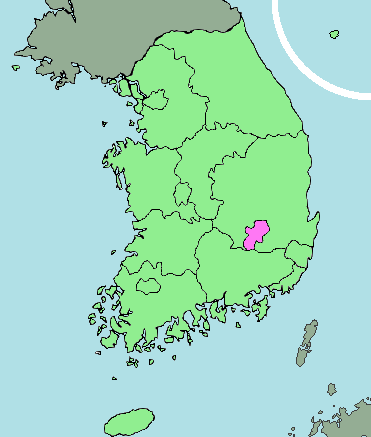
    3. What about population (density) than elderly proportion?
        - Without the outliers (Daegu, Gyeongsangbuk-do)
          the two most infected regions, Gyeonggi-do and Seoul, are the most populated regions
- reference: [wikipedia - Map of South Korea with Daegu highlighted](https://simple.wikipedia.org/wiki/Daegu#/media/File:Daegu_SK.png) 

In [ ]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Confirmed Cases by Region (without 2 outliers - most to least)', fontsize=17)
plt.xticks(rotation=37)
plt.bar(loc_latest_all[2:].province
        , loc_latest_all[2:].confirmed
        , color=color_list[1])
plt.xlabel('region')
plt.ylabel('Number of cases')
plt.show()

Population / Population Density in S.Korea (as of 2018)
- reference - [National Index Portal](http://index.go.kr/potal/main/EachDtlPageDetail.do?idx_cd=1007)

In [ ]:
pop_dense = pd.DataFrame()
pop_dense['region'] = loc_latest_all.province
pop_dense['population'] = np.divide(
    [2450, 2674, 13031, 9705, 2180, 3400
     , 3356, 304, 2939, 1154, 1619, 1521
     , 1518, 1493, 1820, 1790, 653]
    , 1000 # thousand to million
)

# density = number of people / km²
pop_dense['density'] = [2773, 141, 16034, 1279, 265, 4416
                        , 318, 653, 2764, 1088, 219, 90
                        , 2813, 2980, 226, 145, 353]
pop_dense

Population

In [ ]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Population (order by confirmed cases - most to least)', fontsize=17)
plt.bar(pop_dense.region, pop_dense.population, color=color_list[1])
plt.xticks(rotation=43)
plt.xlabel('Region')
plt.ylabel('Number of people (millions)', size=13)
plt.show()

Population Density

In [ ]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Population Density (order by confirmed cases)', fontsize=17)
plt.bar(pop_dense.region, pop_dense.density, color=color_list[1])
plt.ylabel('Number of people (per km²)', size=13)
plt.xlabel('Region')
plt.xticks(rotation=43)
plt.show()

Snap Analysis - population (density) and confirmed cases
    1. Population shows positive correlation in general 
        - the more populations, the more infections (without 2 outliers)
    2. Population density seems to have no correlation with confirmed cases
        - what's clearer is the trend that urban areas have distinctively more cases than rural
    3. Seoul is the outlier among these cities
        - most crowded as the capital of S.Korea 
        - but has a relatively low infection rate
        - which shows preventing and mitigating infections are possible even in a megacity

<a id='eda_sex'></a>
> # [[EDA]](#table) 3. Sex

In [ ]:
sex_raw = get_data(file_paths[3])
data_range(sex_raw, 'date')

Confirmed cases

In [ ]:
fig, ax = plt.subplots(figsize=(11, 11))
plt.title(f'Confirmed Cases Distribution by Sex ({last_update})', fontsize=17)
pop_circle=plt.Circle((0,0), 0.79, color='black')
plt.pie(sex_raw.confirmed[-2:]
        , labels=['male', 'female']
        , autopct='%.2f%%'
        , startangle=90
        , counterclock=False)
p=plt.gcf()
p.gca().add_artist(pop_circle)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Confirmed Cases by Sex (cumulative)', fontsize=17)
sex_confirmed = (sex_raw[sex_raw.sex=='male'].confirmed, sex_raw[sex_raw.sex=='female'].confirmed)
for sex_each, sex_label in zip(sex_confirmed, ['male', 'female']):
    plt.plot(sex_raw.date.unique(), sex_each, label=sex_label)
ax.set_xticks(ax.get_xticks()[::7])
plt.xlabel('Date')
plt.ylabel('Number of cases')
ax.legend()
plt.show()

Snap Analysis - sex and confirmed cases
    1. There have been more female patients for all the documented time
    2. The gap has been growing up to 2020-04-06 and stabilized after then
    3. More males got infected daily from starting of May

Deceased cases

In [ ]:
fig, ax = plt.subplots(figsize=(11, 11))
plt.title(f'Deceased Cases Distribution by Sex ({last_update})', fontsize=17)
pop_circle=plt.Circle((0,0), 0.79, color='black')
plt.pie(sex_raw.deceased[-2:]
        , labels=['male', 'female']
        , autopct='%.2f%%'
        , startangle=90
        , counterclock=False)
p=plt.gcf()
p.gca().add_artist(pop_circle)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Deceased cases by sex (cumulative)', fontsize=17)
sex_deceased = (sex_raw[sex_raw.sex=='male'].deceased, sex_raw[sex_raw.sex=='female'].deceased)

for sex_each, sex_label in zip(sex_deceased, ['male', 'female']):
    plt.plot(sex_raw.date.unique(), sex_each, label=sex_label)
ax.set_xticks(ax.get_xticks()[::7])
plt.xlabel('Date')
plt.ylabel('Number of cases')
ax.legend()
plt.show()

Snap Analysis - sex and deceased cases
    1. There have been more deceased males almost all the time
    2. The gap is narrower than that of confirmed cases
    3. Some underlying factors could cause male's higher fatality (e.g. smoking)
Is there any difference of sex in population itself?

Population Sex Balance - total
- reference: [KOSIS - Korean Statistical Information Service](http://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_1YL20701&vw_cd=MT_GTITLE01&list_id=101&seqNo=&lang_mode=ko&language=kor&obj_var_id=&itm_id=&conn_path=MT_GTITLE01)

In [ ]:
fig, ax = plt.subplots(figsize=(11, 11))
plt.title('Population Sex Balance (2020-02)', fontsize=17)
pop_circle=plt.Circle((0,0), 0.79, color='black')
plt.pie([25984136, 25860491]
        , labels=['male', 'female']
        , autopct='%.2f%%'
        , startangle=90
        , counterclock=False)
p=plt.gcf()
p.gca().add_artist(pop_circle)
plt.show()

Sex balance index
    1. sex_bal = 100: totally balanced
    2. sex_bal < 100: more female
    3. sex_bal > 100: more male

In [ ]:
pop_meta = pop_dense.copy()
pop_meta['sex_bal'] = [97.7, 101.4, 101.2, 95.1, 104.0, 96.3, 101.3, 99.4, 100.5
                          , 105.7, 102.7, 101.2, 99.8, 98.0, 98.9, 100.9, 101.1]
pop_meta

In [ ]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Population sex Balance by Region (order by confirmed cases)', fontsize=17)
plt.xticks(rotation=43)
plt.bar(pop_meta.region, pop_meta.sex_bal, color=color_list[3])
plt.xlabel('Region')
plt.ylabel('Sex balance')
plt.show()

Snap Analysis - population sex balance by region
    1. Sex seems balanced as a whole and in each region
    2. It shows no correlation with the number of confirmed cases
    3. There are no outlier region
        - by outlier rule: less than Q1-1.5*IQR or bigger than Q3+1.5*IQR
- Q1: 25% quartile | Q3: 75% quartile | IQR: InterQuartile Range (Q3 - Q1)

<a id='eda_test'></a>
> # [[EDA]](#table) 4. Test

In [ ]:
test_raw = get_data(file_paths[4])
data_range(test_raw, 'date')

Cumulative Cases

In [ ]:
def plot_test(data, column_list, column_max, case_type):
    for i in column_list:
        fig, ax = plt.subplots(figsize=(13, 7))
        plt.title(f'{case_type} Cases', fontsize=17)
        color_group = color_list[:-4][-(column_max-i):]
        for test_each, color_each in zip(data.columns[i:column_max], color_group):
            plt.plot(data.date, data[test_each], label=test_each
                     , color=color_each
                    )
            label=data[test_each]
        ax.set_xticks(ax.get_xticks()[::11])
        plt.xlabel('Date')
        plt.ylabel('Number of cases')
        ax.legend()
        plt.show()

plot_test(test_raw, [2, 4, 5, 6], 7, 'Cumulative')

In [ ]:
total_pop = sum(pop_meta.population)*1000000
test_raw['test_rate'] = test_raw.test/total_pop * 100
test_raw['confirmed_rate'] = test_raw.confirmed/test_raw.test * 100 # to total tests
test_raw['deceased_rate'] = test_raw.deceased/(test_raw.released+test_raw.deceased) * 100 # to released or deceased cases
print('[Latest test numbers]')
test_raw.tail(1).T

Snap Analysis - test rate / confirmed rate / deceased rate
    1. Test rate to total population: 1.76%
        - increasing (from 0.64% on 2020-03-22)
    2. Confirmed rate to test cases: 1.26%
        - decreasing (from 2.68% on 2020-03-22)
    3. Deceased rate to the cases with result (released or deceased): 2.53%
        - decreasing (from 3.45% on 2020-03-22)

Daily new cases

In [ ]:
print('# Columns for daily new cases added')
for col in test_raw.columns[2:7]:
    if col in [2, 4]:
        new_dict = {0: 1}
    else:
        new_dict = {0: 0}
    new_dict.update({ i : test_raw[col][i] - test_raw[col][i-1] for i in range(1, len(test_raw)) })
    test_raw[f'new_{col}'] = new_dict.values()
    
print('\n[Sample data]')
test_raw.head(3).append(test_raw.tail(3)).T

In [ ]:
plot_test(test_raw, [10, 12, 13, 14], len(test_raw.columns), 'Daily')

Snap Analysis - daily new cases
    1. Test / negative / confirmed cases have been decreasing since the peak with 813 confirmed cases
    2. Test and negative cases peaked again with increase of new confirmed cases in the 2nd week of May
    3. Released / deceased cases kept increasing up to 1 month after the peak then began to decreasing

<a id='eda_path'></a>
> # [[EDA]](#table) 5. Path

In [ ]:
path_raw = get_data(file_paths[5])
print(f'Number of unique paths: {len(path_raw.infection_case.unique())}\n')
print('[6 paths with the most confirmed cases]')
path = path_raw.sort_values('confirmed', ascending=False)
display(path.head(6))

Path distribution

In [ ]:
# Put paths other than those with the 6 most confirmed cases into others
path.loc[len(path), :] = path[path.confirmed<path.confirmed.iloc[5]].sum()
path.loc[len(path)-1, 'case_id'] = 0
path.loc[len(path)-1, 'province'] = 'various regions'
path.loc[len(path)-1, 'city'] = 'various cities'
path.loc[len(path)-1, 'group'] = 'various groups'
path.loc[len(path)-1, 'infection_case'] = 'others'
path.loc[len(path)-1, 'latitude'] = '-'
path.loc[len(path)-1, 'longitude'] = '-'
path_with_others = path[path.confirmed >= path.confirmed.iloc[5]]

# Plot distribution
fig, ax = plt.subplots(figsize=(11, 11))
plt.title(f'Path of Transmission ({last_update})', fontsize=17)
pop_circle=plt.Circle((0,0), 0.79, color='black')
plt.pie(path_with_others.confirmed, autopct='%.2f%%'
        , labels=path_with_others.infection_case + ' (' + path_with_others.province + ')'
#         , explode=(0.03, 0, 0, 0, 0, 0, 0)
        , startangle=90
        , counterclock=False)
p=plt.gcf()
p.gca().add_artist(pop_circle)
plt.show()

Snap Analysis - path of transmission
    1. 'Shincheonji Church' (in Daegu + Gyeongsangbuk-do) has about 50% of all infections logged in this dataset
        - this religious group is said to be with hundreds of thousands members nationwide
    2. There could be secondary infections by this event in these areas as the category of 'contatct with patients'
    3. Summing up, up to 60% of infections are suspected to occur by this single event
        - showing how important the effort of preventing and detecting this type of mass gatherings is

In [ ]:
path_group = path_raw.groupby('group').sum().sort_values('confirmed', ascending=False)
path_group.index = ['group', 'individual']
print('[Type of transmission]')
path_group

In [ ]:
fig, ax = plt.subplots(figsize=(11, 11))
plt.title(f'Type of Transmission ({last_update})', fontsize=17)
pop_circle=plt.Circle((0,0), 0.79, color='black')
plt.pie(path_group.confirmed
        , autopct='%.2f%%'
        , labels=path_group.index
        , startangle=90
        , counterclock=False)
p=plt.gcf()
p.gca().add_artist(pop_circle)
plt.show()

Snap Analysis - type of transmission
    1. In accordance with above (path of transmission), about 70% transmissions occured in group
    2. This figure includes other group events like transmissions at workplaces and clubs
    3. The first focus of prevention must be on groups

<a id='eda_weather'></a>
> # [[EDA]](#table) 6. Weather

In [ ]:
weather_raw = get_data(file_paths[6], transpose=True)
data_range(weather_raw, 'date')

Unique regions

In [ ]:
## Stats by group
print('Number of regions in weather data:', len(weather_raw.province.unique()))
print(sorted(weather_raw.province.unique()))
print()
print('Number of regions in region data:', len(region_raw.province.unique()))
print(sorted(region_raw.province.unique()))

- 'Sejong' (3rd to last in region data) is absent in weather data

In [ ]:
print('[Basic statistics - total]')
weather_raw.loc[:,'avg_temp':].describe().T

In [ ]:
print('[Average weather by region - sample]')
weather_stat = weather_raw.loc[:, 'province':].groupby('province').mean()
weather_stat.tail(3).T

Average weather features by region (order by confirmed cases)

In [ ]:
# Create a dataframe with selective average features
weather_avg = pd.DataFrame(
    [weather_stat.index
     , weather_stat['avg_temp']
     , weather_stat['precipitation']
     , weather_stat['max_wind_speed']
     , weather_stat['avg_relative_humidity']]
    ).T
weather_avg.columns = ['region', 'temperature', 'precipitation'
                       , 'max_wind_speed', 'relative_humidity']

# Order by confirmed cases
sorter = list(pop_meta.region[pop_meta.region != 'Sejong'].values)
weather_avg.region = weather_avg.region.astype('category')
weather_avg.region.cat.set_categories(sorter, inplace=True)
weather_avg = weather_avg.sort_values(['region'])
weather_avg.index = range(len(weather_raw.province.unique()))

# Plot each feature
title_list = ['Average temperature', 'Average Maximun Wind Speed', 'Average relative humidity']
for col, title in zip(weather_avg.columns[[1, 3, 4]], title_list):
    plt.figure(figsize=(13, 7))
    plt.title(f'{title} (since 2016-01-01)', fontsize=17)
    plt.xticks(rotation=41)
    plt.bar(weather_avg.region, weather_avg[col], color=color_list[2])
    plt.xlabel('Region')
    plt.ylabel('Average value')
    plt.show()

Snap Analysis - weather and confirmed cases (since 2016-01-01)
    1. There seems no clear correlations
    2. S.Korea shows a uniform weather in general
        - there are some outstanding cases like maximun wind speed in Jeollanam-do
    3. We are now seeing the general picture of weather for more than 4 years
        - What about only the period after COVID-19 outbreak in S.Korea? (2020-01-20)

Average weather - since 2020-01-20

In [ ]:
## 1. Create a dataframe
weather_covid = weather_raw[weather_raw.date >= '2020-01-20']
weather_cov_stat = weather_covid.loc[:, 'province':].groupby('province').mean()
weather_cov_avg = pd.DataFrame(
    [weather_cov_stat.index
     , weather_cov_stat['avg_temp']
     , weather_cov_stat['precipitation']
     , weather_cov_stat['max_wind_speed']
     , weather_cov_stat['avg_relative_humidity']]
    ).T

## 2, Order by confirmed cases
weather_cov_avg.columns = ['region', 'temperature', 'precipitation'
                           , 'max_wind_speed', 'relative_humidity']
weather_cov_avg.region = weather_cov_avg.region.astype('category')
weather_cov_avg.region.cat.set_categories(sorter, inplace=True)
weather_cov_avg = weather_cov_avg.sort_values(['region'])

## 3. Plot values
title_list = ['Average temperature', 'Average Maximun Wind Speed', 'Average relative humidity']
for col, title in zip(weather_cov_avg.columns[[1, 3, 4]], title_list):    
    plt.title(f'{title} (since 2020-01-20)', fontsize=17)
    plt.xticks(rotation=41)
    plt.bar(weather_avg.region, weather_cov_avg[col], color=color_list[2])
    plt.xlabel('region')
    plt.ylabel('Average value')
    plt.show()

Snap Analysis - weather and confirmed cases (since 2020-01-20)
    1. Temperature : weak negative correlation in general (the colder, the more cases)
    2. Maximum wind speed : weaker positive correlation (the more wind, the more cases)
        - except for the last two regions
    3. Humidity : little or no correlation
As a whole, there seems no significant correlation between the weather and the number of cases

<a id='eda_patient'></a>
> # [[EDA]](#table) 3.7. Patient

In [ ]:
patient_raw = get_data(file_paths[7], transpose=True)
data_range(patient_raw, 'confirmed_date', describe='confirmed date')

In [ ]:
confirmed_total = test_raw.confirmed.iloc[-1]
print(f'Number of confirmed cases in test data ({last_update}):', confirmed_total)

In [ ]:
# Ratio checker
len(patient_raw), confirmed_total, len(patient_raw)/confirmed_total

Data size
    1. The informations on 35% patients are logged in patient data (among 11468 confirmed patients)
    2. Which means 65% patients are confirmed but under-documented

Representativeness of patient data (sex)

In [ ]:
print('Unique sex values:', patient_raw.sex.unique())
print('Number of nan values:', patient_raw.sex.isna().sum())

In [ ]:
sex_dis = patient_raw[['patient_id', 'sex']].groupby('sex', as_index=False).count()
sex_dis.columns = ['sex', 'confirmed']

fig, ax = plt.subplots(figsize=(11, 11))
plt.title('Sex Distribution of Confirmed Cases (in patient data)', fontsize=17)
pop_circle=plt.Circle((0,0), 0.79, color='black')
plt.pie(sex_dis.confirmed
        , labels=[f'female ({sex_dis.confirmed[0]})', f'male ({sex_dis.confirmed[1]})']
        , autopct='%.2f%%'
        , startangle=90
        , counterclock=False)
p=plt.gcf()
p.gca().add_artist(pop_circle)
plt.show()

Compare with sex data

In [ ]:
# get proportion in patient data
sex_dis['proportion'] = round(sex_dis.iloc[:,-1]
                                 /sum(sex_dis.confirmed) * 100, 2).values
# get proportion in sex data
sex_raw_dis = sex_raw.iloc[-2:, [2,3]]
sex_raw_dis['proportion'] = round(sex_raw_dis.iloc[:,-1]
                                     /sum(sex_raw_dis.confirmed) * 100, 2).values
# show difference
print('[Sex distribution in patient data]')
display(sex_dis.sort_values('confirmed', ascending=False))
print('[Sex distribution in sex data]')
display(sex_raw_dis.sort_values('confirmed', ascending=False))

Snap Analysis - representativeness of patient data (sex)
    1. The distribution is similar (more female than male)
    2. The differences between sexs are different (about 10%p in pateint data VS. 16%p in sex data)
    3. This might come from the missing patients logs in patient data
We better recognize this limit while examining other columns which only exist in patient data
(infection_order, contact_number, state)

Infection Order
    # 1 = not infected by other patients in S.Korea
    # 2 = infected by the 1st-order patient
    # and so forth

In [ ]:
print('Number of unique infection orders:', len(patient_raw.infection_order.unique()))
print(patient_raw.infection_order.unique())
print('Number of non-nan values: ', len(patient_raw) - sum(patient_raw.infection_order.isna()))

print('[Distribution by order]')
order_stat = patient_raw[['patient_id', 'infection_order']].groupby('infection_order').count()
order_stat.columns = ['no_of_patients']
display(order_stat)

- The number of values is too small to get a meaningful insight from

Number of contacts (by a patient before being confirmed)
    # 0 = no contact with other patients
    # 1 = contacted (and possibly infected) 1 person which turned out to be confirmed too
    # and so forth

In [ ]:
## Cleanse data
# 1) Drop non numeric values
patient_raw.contact_number = patient_raw.contact_number.replace('-', None)
contact_not_null = patient_raw.contact_number.dropna()
# 2) Convert numeric but str type values into int type 
contact_not_null = pd.Series(map(int, contact_not_null))
# 3) Drop unreasonably large values
contact_not_null = contact_not_null[ contact_not_null < 10000 ]

print('[Basic statistics]')
contact_not_null.describe()

In [ ]:
print('[Distribution by order]')
order_stat = patient_raw[['patient_id', 'infection_order']].groupby('infection_order').count()
order_stat.columns = ['no_of_patients']
display(order_stat)

- The number of values is too small to get a meaningful insight from

Number of contacts (by a patient before being confirmed)
    # 0 = no contact with other patients
    # 1 = contacted (and possibly infected) 1 person
    # and so forth

In [ ]:
## 1. Cleanse data
# 1) Drop non numeric values
patient_contact = patient_raw[ ~patient_raw.contact_number.isna() ]
# 2) Convert numeric but str type values into int type 
patient_contact.contact_number = list(map(int, patient_contact.contact_number))
# 3) Drop unreasonably large values
patient_contact = patient_contact[ patient_contact.contact_number < 10000 ]

## 2. Check statistics
print('[Basic statistics]')
display(patient_contact.contact_number.describe())

## 3. Plot distribution
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Patient Distribution by Number of Contacts Before Confirmed', fontsize=17)
sns.swarmplot(patient_contact.contact_number, color = color_list[5])
ax.set_xlabel('Number of contacts', size=13)
ax.set_ylabel('Patients', size=13)
plt.show()

Snap Analysis - number of contacts by a patient
    1. The size of logs is not enough to represent all patients (678 contacts logs among 4004 patients logs)
    2. 50% have less than or equal to 4 | 75% have less than or equal to 14 contacts history
    3. There are outliers with more than 200 contacts
        - applying a stricter empirical method than statistical outlier rules [Q3 + 1.5*IQR]
        - the outliers among these outliers have more than 1,000 contacts

In [ ]:
print('[Outliers with more than or equal to 200 contacts]')
patient_outliers = patient_contact[patient_contact.contact_number >= 200].sort_values('contact_number', ascending=False)
print('Number of outliers:', len(patient_outliers))
patient_outliers[ ['contact_number', 'sex', 'age', 'country', 'province', 'disease', 'infection_case', 'confirmed_date', 'state'] ]

Snap Analysis - outliers (7 out of 678 contacts logs)
    1. SEX - female: 3 | male: 4
    2. AGE - 10s: 1 | 20s: 1 | 30s: 1 | 40s: 2 | 50s: 1 | 60s: 1
    3. NATIONALITY - Korean: 5 | Chinese: 2
    4. URBAINTY - all living in the urban area (major cities)
    5. UNDERLYING DISEASE - none
    6. CONFIRMED DATE - all in 2020-02
    7. STATE - isolated: 1 | released: 6 (as of 2020-06-02)

In [ ]:
patient_inliers = patient_contact[ ~patient_contact.patient_id.isin(patient_outliers.patient_id) ]
print('[Inliers with less than 200 contacts - sample]')
patient_inliers = patient_inliers[~patient_contact.contact_number.isna()] # without null contacts
display(patient_inliers.sort_values('contact_number', ascending=False)\
[ ['contact_number', 'sex', 'age', 'country', 'province', 'disease', 'infection_case', 'confirmed_date', 'state'] ].tail(3))
print('Number of inliers:', len(patient_inliers))

In [ ]:
print('[Average contacts by date - sample]')
patient_time_contact = patient_inliers[['contact_number', 'confirmed_date']].groupby('confirmed_date').mean()
patient_time_contact.head(3).append(patient_time_contact.tail(3))

In [ ]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Average contacts of a patient (by confirmed date)', fontsize=17)
plt.bar(patient_time_contact.index
        , patient_time_contact.contact_number
        , color = color_list[5])
ax.set_xlabel('Confirmed date', size=13)
ax.set_ylabel('Number of contacts', size=13)
ax.set_xticks(ax.get_xticks()[::9])
plt.show()

Snap Analysis - average contacts by time
    1. Negative correlation in general (excluding the days with an exceptional spike)
        - the more recently a person was confirmed, the less contacts she or he had before the diagnosis
    2. It might be because of the stricter social distancing and growing public awareness as time went by
    3. This means the outbreak of outliers is not just the fault of individuals but the failure of the guidance too
        - in other more hopeful words, it CAN be prevented by the right measures at the right time

<a id='eda_activity'></a>
> # [[EDA]](#table) 8. Activity

In [ ]:
activity_raw = get_data(file_paths[8])
data_range(activity_raw, 'date')

In [ ]:
print(f'Number of logs: {len(activity_raw)}')
print(f'Number of logged regions: {(len(activity_raw.province.unique()))} (except for Sejong)')
print(sorted(activity_raw.province.unique()))

Activity log distribution by region

In [ ]:
# Make a dataframe
activity_region = pd.DataFrame()
activity_region['region'] = activity_raw.groupby('province').count().index
activity_region['logs'] = activity_raw.groupby('province').count().patient_id.values
# Order by the number of logs
activity_region = activity_region.sort_values('logs', ascending=False)
activity_region
# Put other than top 7 regions into others
activity_region.loc['others', 'logs'] = activity_region.iloc[7:,1].sum()
activity_region.loc['others', 'region'] = 'others'
# Keep only 7 & others rows
activity_region = activity_region[ activity_region.logs >= activity_region.iloc[6,1]]
# Plot distribution
fig, ax = plt.subplots(figsize=(11, 11))
plt.title(f'Activity Log Distribution by Region ({last_update})', fontsize=17)
pop_circle=plt.Circle((0,0), 0.79, color='black')
plt.pie(activity_region.logs
        , labels=activity_region.region
        , autopct='%.2f%%'
        , startangle=90
        , counterclock=False)
p=plt.gcf()
p.gca().add_artist(pop_circle)
plt.show()

Snap Analysis - activity log distribution by region
    1. Activity logs from various regions are added
        - more than 90% logs were in Seoul (as of 2020-03-30)
    2. Thus the variety and representativeness of the data increased
        - more than 97% logs were in the capital metropolitan area (as of 2020-03-30)
    3. Nonetheless it's still not matching with the distribution of the confirmed cases
        - which has Daegu at the 1st place, while Daegu is out of the 7 regions with most activity logs

Patients distribution by number of activity logs

In [ ]:
## 1. Make a dataframe
activity_patient = pd.DataFrame()
activity_patient['patient'] = activity_raw.groupby('patient_id').count().index
activity_patient['logs'] = activity_raw.groupby('patient_id').count().date.values
activity_patient = activity_patient.sort_values('logs', ascending=False)
activity_patient.head(3).append(activity_patient.tail(3))
## 2. Swarmplot
fig, ax = plt.subplots(figsize=(13, 7))
plt.title(f'Patients Distribution by Number of Activity Logs ({last_update})', fontsize=17)
ax.set_xlabel('Number of activity logs', size=13)
ax.set_ylabel('Patients', size=13)
sns.swarmplot(activity_patient.logs.values, color = color_list[6])
plt.show()

In [ ]:
print('[Basic stats]')
activity_patient.logs.describe()

In [ ]:
# Ratio checker
len(activity_patient)/confirmed_total

Snap Analysis - activity log distribution by patient
    1. The activities of 1472 patients were logged (around 12% of total confirmed patients)
    2. 50% of them have <= 4 activity logs
    3. 75% of them have <= 7 activity logs

In [ ]:
print('Number of outliers (by rule of \'Q3+1.5*IQR\'):', len(activity_patient[ activity_patient.logs > 14 ]))

Edge cases - patients with the 3 most activity logs

In [ ]:
edge_ids = activity_patient.head(3).patient.values
patient_raw[ (patient_raw.patient_id == edge_ids[0]) | (patient_raw.patient_id == edge_ids[1]) | (patient_raw.patient_id== edge_ids[2]) ].T

In [ ]:
# Number checker
loc_latest_all[ loc_latest_all.province =='Gangwon-do' ].confirmed.values, activity_region[ activity_region.region =='Gangwon-do' ].logs.values

Snap Analysis - edge cases in activity log
    1. None of these 3 are living in the regions with 2 most cases (Deagu, Gyeongsangbuk-do)
    2. This might not mean the less activities in the 2 regions 
        - but the lack of activity logs there
    3. Gangwon-do (region of 1 edge case) has about 50 patients with more than 300 activity logs of them
        - whereas Deague has more than 6500 patients with less than 300 activity logs
        - there could be the hidden edge cases in those regions with most patients

Acitivty log distribution by place (sample)

In [ ]:
# Make a dataframe
activity_type = pd.DataFrame()
activity_type['activity'] = activity_raw.groupby('type').count().index
activity_type['logs'] = activity_raw.groupby('type').count().patient_id.values
activity_type = activity_type.sort_values('logs', ascending=False)
print('Number of unique activities: ', len(activity_type))
# Plot distribution
fig, ax = plt.subplots(figsize=(13, 7))
plt.title(f'Activity Log Distribution by Place ({last_update})', fontsize=17)
ax.set_xlabel('Place', size=13)
ax.set_ylabel('Number of logs', size=13)
plt.bar(activity_type.activity[:7], activity_type.logs[:7], color = color_list[6], width=0.5)
plt.show()

Snap Analysis - activity log distribution by place
    1. (General) hospitals are the most frequently visited place by patients before confirmed
        - hospital | office | public-transportation were top 3 (as of 2020-03-30)
    2. Stores, public transportations and restaurants follow hospitals with a distinct gap
        - it seems that office category has been transferred into 'etc'
        - as there are no office or work-related places anymore in activity logs
    3. If this is not just a matter of sorting but of the actaul trend shifting,
       it could be an alarm for the relaxed social distancing and public awareness

<a id='eda_seoul'></a>
> # [[EDA]](#table) 9. Seoul

In [ ]:
seoul_raw = get_data(file_paths[9])
data_range(seoul_raw, 'date')

Data Description - snapshot on active population in Seoul (the capital of S.Korea)
    1. 864,000 rows in sum
    2. They show each day's floating population (7200 rows per day)
    3. These are divided by coulumns of 'hour > birth_year > sex > city(subregion, in fact)'
        - all 'province(city, in fact)' are Seoul

In [ ]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Floating Population by Date', size=17)
plt.bar(seoul_raw.date.unique()
       , seoul_raw.groupby(['date', 'hour']).sum()\
         .groupby('date').mean().apply(lambda x: x/1000000)\
         .fp_num.values
       , color=color_list[7])
ax.set_xlabel('Date', size=13)
ax.set_ylabel('Floating population (millions)', size=13)
plt.xticks(rotation=0, size=9)
ax.set_xticks(ax.get_xticks()[::13])
plt.show()

Snap Analysis - floating population by date
    1. Around 17 million people are expected to be active in Seoul daily
        - the data provider, SKT, has 46.24% mobile service market share
        - 8 millions * (100 / 46.24) = 17.30 millions
    2. 2020-01-23 to 2020-01-28 showed lower numbers as it was the new year festival season
        - many people visited their hometown outside of Seoul
    3. What happened on 2020-02-23(spike) and 2020-03-11(dip)?

In [ ]:
## 1. Get hourly floating populations by date
spike_idx = np.argmax(seoul_raw.groupby(['date', 'hour']).sum().groupby('date').mean().fp_num)
dip_idx = np.argmin(seoul_raw.groupby(['date', 'hour']).sum().groupby('date').mean().fp_num)
spike = seoul_raw[ seoul_raw.date == spike_idx ].groupby('hour')\
                                                .sum().apply(lambda x: x/1000000)\
                                                .fp_num
normal = seoul_raw[ seoul_raw.date == '2020-02-16' ].groupby('hour')\
                                                    .sum().apply(lambda x: x/1000000)\
                                                    .fp_num
dip = seoul_raw[ seoul_raw.date == dip_idx ].groupby('hour')\
                                            .sum().apply(lambda x: x/1000000)\
                                            .fp_num
## 2. Compare three days
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Floating Population by Time (outliers VS. normal)', size=17)
plt.plot(spike, color=color_list[7])
plt.plot(normal, color=color_list[0])
plt.plot(dip, color=color_list[2])
ax.set_xlabel('Hour of day', size=13)
ax.set_ylabel('Floating population (millions)', size=13)
plt.legend([f'spike ({spike_idx})'
            , 'normal (2020-02-16)'
            , f'dip ({dip_idx})'
           ], fontsize=11, loc='center right')
plt.show()

Snap Analysis - outlier or error
    1. 2020-02-23/2020-03-11 was just another Sunday/Wednesday (officially and empirically)
    2. In case of the spike day, especially one hour (11 o'clock) shows the similar number to those of the normal days
        - there could have been double counting at the other hours on that day
        - we better halve the other hours to match the level
    3. Whereas the dip day has a stable floating population around the clock
        - we let this part as it is cause we can't assume further only with this similarity

Halving the (suspected) error values in the spike day

In [ ]:
print('[Before havling \'fp_num\']')
display(seoul_raw[(seoul_raw.date==spike_idx) & (seoul_raw.hour!=11) ].tail(1))
seoul_raw.loc[ (seoul_raw.date==spike_idx) & (seoul_raw.hour!=11), 'fp_num' ] /= 2
print('[After havling \'fp_num\']')
display(seoul_raw[(seoul_raw.date==spike_idx) & (seoul_raw.hour!=11) ].tail(1))

Visual check

In [ ]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Floating Population by Time', size=17)
plt.plot(seoul_raw[ seoul_raw.date == '2020-02-23' ].groupby('hour')\
                                                    .sum().apply(lambda x: x/1000000)\
                                                    .fp_num
         , color=color_list[7])
plt.plot(normal, color=color_list[0])
ax.set_ylabel('Floating population (millions)', size=13)
ax.set_xlabel('Hour of day', size=13)
plt.legend(['outlier(2020-02-23)', 'normal(2020-02-16)'], fontsize=11, loc='lower right')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Floating Population by Date', size=17)
plt.bar(seoul_raw.date.unique()
       , seoul_raw.groupby(['date', 'hour']).sum()\
         .groupby('date').mean().apply(lambda x: x/1000000)\
         .fp_num.values
       , color=color_list[7])
ax.set_xlabel('Date', size=13)
ax.set_ylabel('Floating population (millions)', size=13)
plt.xticks(rotation=0, size=9)
ax.set_xticks(ax.get_xticks()[::13])
plt.show()

- corrected

Let's dissect floating populations by feature

Seoul - sex

In [ ]:
# get 2 separate tables by sex
seoul_female, seoul_male = seoul_raw[seoul_raw.sex == 'female'], seoul_raw[seoul_raw.sex == 'male']
# pie chart
fig, ax = plt.subplots(figsize=(11, 11))
plt.title('Floating Population by sex (total)', size=17)
pop_circle=plt.Circle((0,0), 0.79, color='black')
plt.pie([seoul_female.fp_num.sum()
         , seoul_male.fp_num.sum()]
        , labels=['female', 'male']
        , autopct='%.2f%%'
        , startangle=90
        , counterclock=False)
p=plt.gcf()
p.gca().add_artist(pop_circle)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Floating Population by Sex (overlapped)', size=17)
for each, i in zip([seoul_female, seoul_male], range(2)):
    plt.bar(each.date.unique()
       , each.groupby(['date', 'hour']).sum()\
        .groupby('date').mean().apply(lambda x: x/1000000)\
        .fp_num.values
       , color=color_list[i])
ax.set_xlabel('Date', size=13)
ax.set_ylabel('Floating population (millions)', size=13)
plt.xticks(rotation=0, size=9)
plt.legend(['female', 'male'], loc='lower right')
ax.set_xticks(ax.get_xticks()[::13])
plt.show()

Snap Analysis - floating population by sex and date
    1. There were more female than male for the documented days
    2. This doesn't mean the actual proportion of all Seoul floaters must be same
        - regarding the data provider's limited market share (46.24%)
    3. Nonetheless by considering the sex balance of Seoul (95.1 male to 100 female),
       the pattern of more female than male would persist in daily floating populations too

In [ ]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Floating Population by Sex (average per day)', size=17)
plt.plot(seoul_female.groupby(['date', 'hour']).sum()\
         .groupby('hour').mean().apply(lambda x: x/1000000)\
         .fp_num
         , color=color_list[0])
plt.plot(seoul_male.groupby(['date', 'hour']).sum()\
         .groupby('hour').mean().apply(lambda x: x/1000000)\
         .fp_num
         , color=color_list[1])
ax.set_ylabel('Floating population (millions)', size=13)
ax.set_xlabel('Hour of day', size=13)
plt.legend(['female', 'male'], loc='lower right')
plt.show()

- The pattern seems same as that of date

Seoul - age

In [ ]:
float_age_order = list(seoul_raw.groupby('birth_year').sum().sort_values('fp_num', ascending=False).index)
fig, ax = plt.subplots(figsize=(11, 11))
plt.title('Floating Population by Age', size=17)
pop_circle=plt.Circle((0,0), 0.79, color='black')
plt.pie(seoul_raw.groupby('birth_year').sum().sort_values('fp_num', ascending=False).fp_num
        , labels=float_age_order
        , autopct='%.2f%%'
        , startangle=90
        , counterclock=False)
p=plt.gcf()
p.gca().add_artist(pop_circle)
plt.show()

Snap Analysis - floating population by age
    1. Age range starts/ends with 20s/70s unlike age_raw data (which starts/ends with 0s/80s)
    2. It seems that 20s means <=29 and 70s does >=70 in seoul_raw
    3. Let's validate with the resident population

Resident population by age (as of 2019-09)
- applying 20s = 0s + 10s + 20s / 70s = 70s + 80s + 90s + older than 100
- reference: [Seoul open data](https://data.seoul.go.kr/dataList/10718/S/2/datasetView.do#none)

In [ ]:
seoul_pop_dis = {'20s': 682490 + 841476 + 1539441, '30s': 1572046, '40s': 1608068
                 , '50s': 1608155, '60s': 1192140, '70s': 681810 + 255068 + 39036 + 6197}
fig, ax = plt.subplots(figsize=(11, 11))
plt.title('Resident Population by Age', size=17)
pop_circle=plt.Circle((0,0), 0.79, color='black')
plt.pie(seoul_pop_dis.values()
        , labels=seoul_pop_dis.keys()
        , autopct='%.2f%%'
        , startangle=90
        , counterclock=False)
p=plt.gcf()
p.gca().add_artist(pop_circle)
plt.show()

Snap Analysis - resident population by age (compared to floating population)
    1. The order and proportions are simliar to that of floating population
        - except that 20s became the most populated group
        - by our assumption 20s means <=29 in floating population
    2. 20's floating populations might refer to 20s only
        - while 70s means >=70s since the porportion matches
    3. When it comes to 0s and 10s, they seem to be included in 30s ~ 50s
        - because most of their caregivers are expected to be 30s ~ 50s
        - and they make contracts with a mobile company on behalf of their children

In [ ]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Floating Population by Age (overlapped)', size=17)
for age, i in zip(float_age_order, range(len(float_age_order))):
    plt.bar(seoul_raw.date.unique()
            , seoul_raw[seoul_raw.birth_year==age].groupby(['date', 'hour']).sum()\
            .groupby('date').mean().apply(lambda x: x/1000000)\
            .fp_num.values
            , color=color_list[i])
ax.set_xlabel('Date', size=13)
ax.set_ylabel('Floating population (millions)', size=13)
plt.xticks(rotation=0, size=9)
plt.legend(float_age_order
           , loc='lower right'
          )
ax.set_xticks(ax.get_xticks()[::13])
plt.show()

Snap Analysis - floating population by age and date
    1. On 2020-02-02 the number of 60s and 70s dropped about 10% (0.1 millions)
        - and kept being similar till the last day of logging
    2. Other age groups showed the same pattern as usaul for that period
    3. This could be explained by the fact that most workers in Seoul are in their 20s~50s

In [ ]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Floating Population by Age', size=17)
for age, i in zip(float_age_order, np.arange(len(float_age_order))):
    plt.plot(seoul_raw[seoul_raw.birth_year==age].groupby(['date', 'hour']).sum()\
             .groupby('hour').mean().apply(lambda x: x/1000000)\
             .fp_num
             , color=color_list[i])
ax.set_ylabel('Floating population (millions)', size=13)
ax.set_xlabel('Hour of day', size=13)
plt.legend(float_age_order, loc='lower right')
plt.show()

Snap Analysis - floating population by age and hour
    1. 60s and 70s look insensitive to hour as expected above
    2. Whereas 20s, 30s, and 40s have the workers' hill pattern from 6 to 20 (8 p.m.)
    3. 50s seem mixed (passersby + workers)

Seoul - subregion

In [ ]:
float_area_order = list(seoul_raw.groupby('city').sum().sort_values('fp_num', ascending=False).index)

fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Floating Population by Subregion (total)', size=17)
sns.barplot(float_area_order
           , seoul_raw.groupby('city').sum().sort_values('fp_num', ascending=False).fp_num/(seoul_raw.fp_num.sum())*100)
ax.set_xlabel('Subregion', size=13)
ax.set_ylabel('Floating population proportion (%)', size=13)
plt.xticks(rotation=37, size=9)
plt.show()

Confirmed cases by subregion (as of 2020-06-03)
- reference - [Seoul COVID-19](http://www.seoul.go.kr/coronaV/coronaStatus.do)

In [ ]:
## 1. Get confrimed cases by subregion and order of floating population
seoul_confirmed = [76, 49, 50, 44, 31    # Gangnam, Songpa, Gangseo, Seocho, Nowon
                   , 60, 39, 43, 27, 29  # Gwanak, Yeongdeungpo, Guro, Mapo, Seongbuk
                   , 35, 26, 35, 40, 19  # Eunpyeong, Gangdong, Yangcheon, Dongjag, Jungnang
                   , 34, 14, 41, 30, 19    # Dongdaemun, Gwangjin, Seongdong, Seodaemun, Dobong
                   , 16, 16, 9, 19, 38]   # Gangbuk, Geumcheon, Jung, Jongno, Yongsan
float_area_order = list(seoul_raw.groupby('city').sum().sort_values('fp_num', ascending=False).index)

## 2. Plot distribution
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Confirmed Cases by Subregion (order by floating population)', size=17)
sns.barplot(float_area_order
           , seoul_confirmed)
ax.set_xlabel('Subregion', size=13)
ax.set_ylabel('Number of confirmed cases (2020-06-03)', size=13)
plt.xticks(rotation=37, size=9)
plt.show()

Snap Analysis - confirmed cases and floating population
    1. Positive correlation in general
        - the more people are floating around, the more infections could be
    2. Most cases in Seoul are from abroad and group infections (like workplaces and clubs)
        - which could have something to do with the floating population in those areas
        - regarding the difference in wealth and the concentration of workplaces in downtown
    3. But the absolute number of cases in each subregion is too small to draw a strong conlcusion from

<a id='eda_search'></a>
> # [[EDA]](#table) 10. Search

Data description
    1. More than 4 years of search trends on 4 topics related to respiratory diseases (cold / flu / pneumonia / coronavirus)
    2. 100% means the highest interest in the time range while the others are relative to this
    3. Data provider: Naver (one of the influential search engines in S.Korea, market share=17.42%)
- reference: [Search engine market share](https://gs.statcounter.com/search-engine-market-share/all/south-korea) (as of 2020-05)

In [ ]:
search_raw = get_data(file_paths[10])
data_range(search_raw, 'date')

In [ ]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Search Trends Related to Respiratory Diseases (whole period)', size=17)
ax.set_xlabel('Date', size=13)
ax.set_ylabel('Relative interests in time range (%)', size=13)
for column in search_raw.columns[1:]:
    plt.plot(search_raw.date, search_raw[column])
ax.set_xticks(ax.get_xticks()[::int(len(search_raw.date.unique())/8)])
ax.legend()
plt.show()

- As expected, there were only the spikes of seasonal flu and cold before COVID-19 outbreak

In [ ]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Search Trends Related to Respiratory Diseases (since 1st case worldwide)', size=17)
ax.set_xlabel('Date', size=13)
ax.set_ylabel('Relative interests in time range (%)', size=13)
for column in search_raw.columns[1:]:
    plt.plot(search_raw.date[search_raw.date >= '2019-11-17']
             , search_raw[search_raw.date >= '2019-11-17'][column])
ax.set_xticks(ax.get_xticks()[::int(len(search_raw.date[search_raw.date >= '2019-11-17'])/8)])
ax.legend(loc='upper left')
plt.show()

Snap Analysis - search trends after the outbreak of COVID-19 worldwide
    1. No distinct change had occured for about 1 and half months
    2. Increase of searching pneumonia was prior to that of coronavirus(COVID-19)
        - because it's called Wuhan pneumonia at first in S.Korea
            - Wuhan is the assumed place where COVID-19 pandemic started
    3. After then coronavirus kept dominating the search trends
        - on 2020-01-23 (3 days after the 1st case of S.Korea) it reached 100% interests in this time range

In [ ]:
# search trends after 1st case in S.Korea
fig, ax1 = plt.subplots(figsize=(13, 7))
plt.title('Search Trends Related to Respiratory Diseases (since 1st case in S.Korea)', size=17)
ax1.set_xlabel('Days after 2020-01-20', size=13)
ax1.set_ylabel('Relative interests in time range (%)', size=13)
for column in search_raw.columns[1:]:
    ax1.plot(search_raw[search_raw.date >= '2020-01-20'].date
             , search_raw[search_raw.date >= '2020-01-20'][column])
ax1.set_xticks(ax1.get_xticks()[::14])
ax1.legend(loc='upper left')
# daily new cases
ax2 = ax1.twinx()
ax2.grid(False)
ax2.set_ylabel("Number of cases", size=13)
ax2.plot(test_raw.date[:-1]
         , test_raw.new_confirmed[:-1]
         , label='new confirmed', color='dimgray', ls=':', lw=3)
ax2.set_xticks(ax2.get_xticks()[::14])
ax2.legend(loc='upper right')

plt.show()

Snap Analysis - search trends after the outbreak of COVID-19 in S.Korea
    1. After passing the first peak, searching on COVID-19 had been decreasing for about 1 month
    2. But around 2020-02-21 the mass confirmations in Daegu occured
        - the search on coronavirus leaped again just before then (2020-02-19)
            - as the public already heard massive infections might be there
    3. The search trends shows an impressive similarity to the shape of daily confirmed cases after then
        - there might be an underlying correlation between them

<a id='eda_policy'></a>
> # [[EDA]](#table) 11. Policy

In [ ]:
policy_raw = get_data(file_paths[11])
data_range(policy_raw, 'start_date', describe='start date')

Preprocessing

In [ ]:
print(f'[Null check]\n{policy_raw.isna().sum()}')

- Too many nulls in end_date (35 out of 57)
    - We will use start_date as reference dates

In [ ]:
print('[Redundancy check]')
print('Are values in \'policy_id\' column just index + 1?')
print(f'# {(policy_raw.index + 1 == policy_raw.policy_id).all()}')
print('Unique countries in \'country\' column:')
print(f'# {policy_raw.country.unique()[0]}')

- We will use only the columns other than above 2 (policy_id, country)
    - Whiling keeping end_date as additional references in case

In [ ]:
## Check redundancy conditions before ruling out
    # index + 1 == policy_id ?
    # country.unique() == Korea ?
if ( sum(policy_raw.index+1==policy_raw.policy_id) == len(policy_raw) 
   ) and ( len(policy_raw.country.unique()) == 1 ):
    policy_compact = policy_raw.iloc[:, 2:]
print('[Sample data - compact version]')
display(policy_compact.tail(3))
print('[Basic numbers]')
display(policy_compact.describe())

Policy distribution (by type / title / starting day / starting month)

In [ ]:
## 1. Policy type distribution
fig, ax = plt.subplots(figsize=(11, 11))
plt.title(f'Policy Type Distribution ({last_update})', fontsize=17)
pop_circle = plt.Circle((0,0), 0.79, color='black')
plt.pie(policy_compact.type.value_counts()
        , labels = policy_compact.type.value_counts().index
        , autopct = '%.2f%%'
        , startangle = 90
        , counterclock = False)
p=plt.gcf()
p.gca().add_artist(pop_circle)
plt.show()

## 2. Policy title distribution (title: specific policies in a type)
# 1) Put others than top 7 into others
policy_titles = pd.DataFrame(policy_compact.gov_policy.value_counts().items(), columns=['title', 'counts'])
policy_titles.loc[len(policy_titles), 'title'] = 'Others'
policy_titles.loc[len(policy_titles)-1, 'counts'] = policy_titles.iloc[6:, 1].sum()
policy_titles = pd.concat([policy_titles[:7], policy_titles[-1:]])

# 2) Plot distribution
fig, ax = plt.subplots(figsize=(11, 11))
plt.title(f'Policy Title Distribution ({last_update})', fontsize=17)
pop_circle = plt.Circle((0,0), 0.79, color='black')
plt.pie(policy_titles['counts']
        , labels = policy_titles['title']
        , autopct = '%.2f%%'
        , startangle = 90
        , counterclock = False)
p=plt.gcf()
p.gca().add_artist(pop_circle)
plt.show()

Snap Analysis - policy distribution (by type / title)
    1. Most frequently implemented policies are on immigration
        - because the immigration policies are speicifc to each country
    2. Next are for educations
        - especially on the delay of school opening and its alternatives (online classes)
    3. 3rd are about public heath
        - the authorization for diagnostic kit, social distancing campaigns, and mask distributions

In [ ]:
## 1. Policy starting day distribution
fig, ax = plt.subplots(figsize=(13, 7))
plt.title(f'Policy Starting Day Distribution ({last_update})', size=17)
sns.swarmplot(policy_compact.start_date)
plt.xlabel('The day of policy implementation', size=13)
plt.ylabel('Policies', size=13)
ax.set_xticks(ax.get_xticks()[::3])
plt.show()

## 2. Policy starting month distribution
policy_by_day = pd.DataFrame(policy_raw.groupby('start_date').count().gov_policy)
policy_by_day['month'] = [ int(policy_by_day.index[i][6:7]) for i in range(len(policy_by_day)) ]
policy_by_month = policy_by_day.groupby('month').sum()
plt.title(f'Policy Starting Month Distribution ({last_update})', size=17)
plt.bar(policy_by_month.index
        , policy_by_month.gov_policy
        , width=0.31)
plt.xlabel('Month', size=13)
plt.ylabel('Number of policies started', size=13)
plt.yticks(np.arange(0, max(policy_by_month.gov_policy)+1, 3))
plt.show()

In [ ]:
# Proportion check
print(policy_by_month.gov_policy[3]
      , sum(policy_by_month.gov_policy)
      , policy_by_month.gov_policy[3]/sum(policy_by_month.gov_policy)*100)

Snap Analysis - policy distribution (by starting day / starting month)
    1. The first policy started on 2020-01-03 
        - by setting infectious disease alert level 1 (blue)
        - which was 17 days before the first case in S.Korea occured
    2. In general the frequency and numbers of policies are evenly distributed
        - 0 to 7 policies were applied per day
    3. About 36% (21/58) policies began in 2020-03

Alert level on infectious disease
    1. Level 1 (blue)
        0) When
            - There is a new epidemic outside of S.Korea
            - An epidemic with unknown causes occurs or the known epidemic reoccurs in S.Korea
        1) Do
            - Set and run a taskforce for each type of epidemics in KCDC (Korea Centers for Disease Control)
            - Monitor the situtation and keep ready for worse scenarios
            - Disinfect the affected area and run the infrastructures for disinfecting (if necessary)
    2. Level 2 (yellow)
        0) When
            - The epidemic from abroad comes into S.Korea
            - An epidemic with unknown causes or the known epidemic spreads in S.Korea to a limited extent
        1) Do
            - Set and run the central taskforce in KCDC
            - Start cooperative work with the related organizations
            - Disinfect the affected area and run the infrastructures for disinfecting
            - Intensify monitoring
    3. Level 3 (orange)
        0) When
            - The epidemic from abroad spreads in S.Korea with to a limited extent
            - An epidemic with unknown causes or the known epidemic spreads in S.Korea community-wide
        1) Do
            - Keep running the central taskforce
            - Set and run another taskforce for handling losses from the epidemic in MOHW (Ministry Of Health and Welfare)
            - Hold a general governmental conference by the prime minister if necessary
            - Check whether it's required to run the general assisting taskforce in MOIS (Ministry Of the Interior and Safety)
            - Intensify cooperative work with the related organizations
            - Intensify disinfecting and monitoring more
    4. Level 4 (red)
        0) When
            - The epidemic from abroad spread in S.Korea community-wide or nation-wide
            - An epidemic with unknown causes or the known epidemic spreads in S.Korea nation-wide
        1) Do
            - Allocate all the governmental offices to areactive efforts
            - Set and run the central taskforce for natural disasters if necessary
- reference : [Korea Centers for Disease Control](http://www.cdc.go.kr/contents.es?mid=a20301020300)

In [ ]:
policy_alerts = policy_compact[ policy_compact.type == 'Alert' ]
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Infectious Disease Alert Level', size=17)
plt.plot(test_raw.date.unique(), test_raw.new_confirmed
         , color='dimgray'
         , lw=3)
ax.set_xticks(ax.get_xticks()[::14])
for day, color in zip(policy_alerts.start_date.values[1:], ['yellow', 'orange', 'red']):
    ax.axvline(day, ls=':', color=color, lw=3)
ax.legend(['new confirmed', 'alert level 2', 'alert level 3', 'alert level 4'], fontsize=11)
plt.ylabel('Number of cases')
plt.show()

Snap Anaylsis - alert level
    1. Level 3 (orange) were applied proactively when there were 4 cumulative confirmed cases
    2. The other levels were implemented following the criteria in the guideline
    3. As of 2020-06-03 the alert level keeps at 4 (red)
       with additional policies for social distancing while running daily lives (a milder version of the previous one)

Policy on public health

In [ ]:
## 1. Get the first implemented health policies by type and title
first_policy = { i[1].start_date.values[0]: i[0].lower() 
                for i in policy_raw[policy_raw.type=='Health'].groupby(['gov_policy']) }
first_policy = dict(sorted(first_policy.items()))

## 2. Plot starting dates
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Policy on Public Health', size=17)
plt.plot(test_raw.date.unique(), test_raw.new_confirmed
         , color='dimgray', lw=3)
ax.set_xticks(ax.get_xticks()[::14])
for date, color in zip(first_policy.keys(), color_list[:4]):
    ax.axvline(date, ls=':', color=color, lw=3)
ax.legend(['new confirmed'] + list(first_policy.values())
          , fontsize=11, loc='upper right')
plt.ylabel('Number of cases')
plt.show()

Snap Analysis - policy on public health
    1. The first authorization for emergency use of diagnositc kit was implemented
       when there were 16 confirmed cases by 607 tests in sum
    2. The first drive-through diagnostic center was launched at local level
       when there were 1,261 cumulative confirmed cases by 53,553 tests (with 284 daily confirmed cases)
    3. The first mask distribution by government was on the next day of opening drive-through centers
       and it has been implemented up to now

Policy on immigration

In [ ]:
## 1. Get the oldest and recent policies on immigration
policy_immi = policy_raw[ policy_raw.type == 'Immigration' ].head(1).append(
              policy_raw[ policy_raw.type == 'Immigration' ].tail(3))
policy_list = list( map(add # 1) add policy titles + country names
                        , map( lambda x: x.lower() # 2) lower case policy titles
                              , policy_immi.gov_policy.values)
                        , map( lambda x: ' (' + x[5:].replace(' the', '') +')' # 3) simplify country names
                              , policy_immi.detail.values)
                       ) 
                  )

## 2. Plot starting dates
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Policy on Immigration', size=17)
plt.plot(test_raw.date.unique(), test_raw.new_confirmed
         , color='dimgray'
         , lw=3)
ax.set_xticks(ax.get_xticks()[::14])
for day, color in zip(policy_immi.start_date.unique(), color_list[:4]):
    ax.axvline(day, ls=':', color=color, lw=3)
ax.legend(['new confirmed'] + policy_list, fontsize=11
           , loc='upper left')
plt.ylabel('Number of cases')
plt.show()

Snap Analysis - policy on immigration
    1. The first policy on immigration procedure was for the visitors from China
    2. The same special procedure was applied to all countries after a month
        - for this month the number of applied countries kept increasing
    3. 14 day self quarantine has been mandatory for all incomers since 2020-03-30
        - with additional diagnostic tests for those from the U.S.

Policy on education

In [ ]:
## Various education policies started on the sames days
    # thus we better handle this empirically than systematically
    # cause it's not generalizable to other use cases
policy_edu = policy_compact[ policy_compact.type == 'Education' ]
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Policy on Education', size=17)
plt.plot(test_raw.date.unique(), test_raw.new_confirmed
         , color='dimgray'
         , lw=3)
ax.set_xticks(ax.get_xticks()[::14])
for day, color in zip(policy_edu.start_date.unique(), color_list[:4]):
    ax.axvline(day, ls=':', color=color, lw=3)
ax.axvline('2020-05-20', ls=':', color=color_list[4], lw=3)
ax.legend(['new confirmed', 'school closure & opening delay'
           , 'online class open (high&middle 3)'
           , 'online class open (high&middle 1,2 / elementary 4~6)'
           , 'online class open (elementary 1~3)'
           , 'physical class open (high 3)'
          ], fontsize=11
           , loc='upper left')
plt.ylabel('Number of cases')
plt.show()

Snap Analysis - policy on education
    1. All schools were closed right after the peak of daily new cases (including children daycare center)
    2. When there were 39 daily cases (yellow line)
       the online classes for 3rd graders in high/middle schools opened
       - and those for the other graders followed
    3. Some graders in some schools in some regions has opened physical schools since 2020-05-20 (blue line)

In [ ]:
## Refactor log - 3rd Jun 2020 Wed

<a id='fc'></a>
# [[FC: ForeCasting]](#table)
    1. How can machine (learning) help us deepen the understandings we have now?
        1) While our human eyes used to focus more on what happened already,
           machine may look beyond to the future objectively and systematically
    2. How much worthy or useful is it to predict the number of infections or deceased victims?
        1) It could help decision makers select more efficient and timely measures to tackle the new cases
        2) It might be helpful for individuals to know how much we need to be serious on preventing efforts
    3. What could be fundamental or neccessary too for anyone in the storm of pandemic?
        1) A general forecasting model not only for S.Korea but for all countries
            - especially for the ones showing the early pattern of spreading
        2) Ways of allocating necessary medical resources nationwide or even worldwide (e.g. ventilator)
            - from the places with the decreasing trend to those with the increasing one

In [ ]:
print('[Datasets we\'ve been through]')
[ i[:-4] for i in file_names ]

    1. We learned by EDA there seems to be a positive correlation between search trends on COVID-19 and the number of daily confirmed cases
    2. we have analysed the search trends in Naver above (market share: 17.42%)
    3. Let's delve into search trends with additional data from Google (market share: 76.52%)
- reference - [Search engine market share](https://gs.statcounter.com/search-engine-market-share/all/south-korea) (2020-05)

<a id='fc_basics'></a>
> # [[FC]](#table) 1. LR / Naive / Average
- LR: Linear Regression

Search trends

In [44]:
## 1. Get data on global confirmed cases and fatalities (which are more recent than test_raw)
test_global = pd.read_csv('./covid19-global-forecasting-week-5/train.csv')
## 2. Pick relevant rows and columns
daily_korea_raw = [0, 0, 0]
daily_korea_raw = test_global[ (test_global.Country_Region=='Korea, South') 
                              & (test_global.Target=='ConfirmedCases') 
                              & (test_global.Date>='2020-01-20') 
                             ].loc[ :, ['Date', 'TargetValue'] ]

In [46]:
## 1. Get data on search trends
search_korea_raw = pd.read_csv('./search/search_southkorea.csv')
## 2. Cleanse nulls and insignificant values
search_korea_raw = search_korea_raw.dropna()
search_korea_raw = search_korea_raw.replace('<1', 0) # <1 means less than 1 significance in raw data
## 3. Convert object to float
search_korea_raw.iloc[:, 1:-2] = search_korea_raw.iloc[:, 1:-2].astype(float)
## 4. Make a new column by merging 5 sub-columns for COVID-19 search on google
search_korea_raw['google(all)'] = search_korea_raw.iloc[:, 1:-1].sum(axis=1)
search_korea_raw['google(all)'] = search_korea_raw['google(all)']/max(search_korea_raw['google(all)']) * 100 # normalizing

## 5. Match lengths between search & case datasets
if len(search_korea_raw) < len(daily_korea_raw):
    daily_korea = daily_korea_raw[:len(search_korea_raw)]
    search_korea = search_korea_raw[3:]
else:
    daily_korea = daily_korea_raw
    search_korea = search_korea_raw[3:3+len(daily_korea)]
daily_korea.index = range(len(daily_korea))
search_korea.index = range(len(search_korea))
print('[Sample data]')
display(search_korea.head(3).append(search_korea.tail(3)))
# 6. Get X, y
shorter_len = min(len(search_korea), len(daily_korea))
X_google = search_korea['google(all)'][:shorter_len]
X_naver = search_korea['naver(all)'][:shorter_len]
y = daily_korea.TargetValue.values[:shorter_len]
date_range = daily_korea.Date[:shorter_len]
# X_google, X_naver, y = np.log(X_google+1), np.log(X_naver+1), np.log(y+1) # log version

[Sample data]


,Day,corona,corona virus,covid,covid19,corona(Kor),naver(all),google(all)
0,1/23/2020,1.0,1.0,0.0,0.0,4.0,19.77503,5.084746
1,1/24/2020,1.0,2.0,0.0,0.0,6.0,17.59853,7.627119
2,1/25/2020,1.0,3.0,0.0,0.0,8.0,13.06011,10.169492
118,5/20/2020,1.0,2.0,0.0,1.0,15.0,9.85471,16.101695
119,5/21/2020,1.0,2.0,0.0,2.0,14.0,8.92189,16.101695
120,5/22/2020,1.0,2.0,0.0,1.0,14.0,8.15162,15.254237


Data Description
    1. Daily search trends since the day with the first confirmed case in S.Korea
    2. Google offers the trend of an individual word, so we use 5 columns for 5 search queries related to COVID-19
        - we merge them into one column (relative significances among words applied)
            - 'corona' + 'corona virus' + 'covid' + 'covid19' + 'corona(Kor)' = 'google(all)'
    3. Naver gives the cumulative result on up to 20 words for 1 search topic
        - Now we gather a new search trends data from Naver for the same date range as Google's
            - to account the relative interests only after the first case (not after 2016-01-01 as in search_raw)
- reference 
    1. [Google trends](https://trends.google.com/trends/explore?date=2020-01-20%202020-05-25&geo=KR&q=corona,coronavirus,covid19,covid,%EC%BD%94%EB%A1%9C%EB%82%98)   (2020-05-25)
    2. [Naver DataLab](https://datalab.naver.com/keyword/trendResult.naver?hashKey=N_77f94e17adc9a88a8b4a09da941777ab)   (2020-05-25)

No handles with labels found to put in legend.


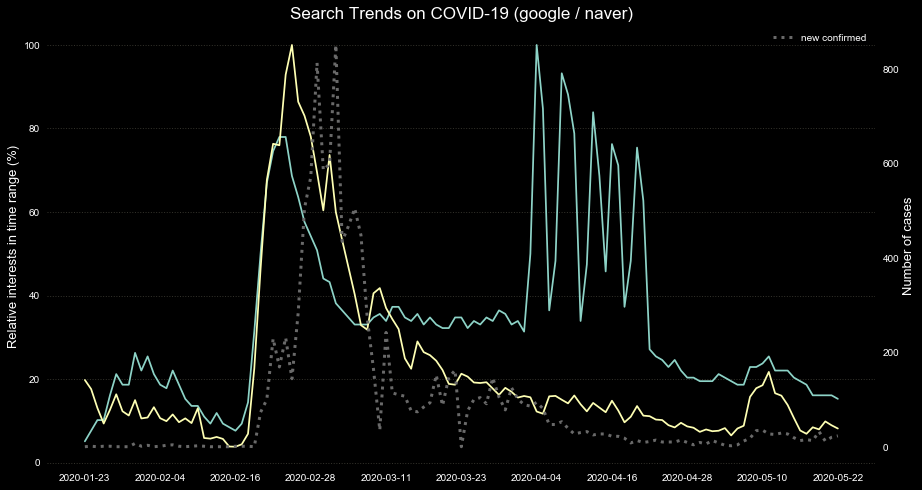

In [47]:
fig, ax1 = plt.subplots(figsize=(13, 7))
plt.title('Search Trends on COVID-19 (google / naver)', size=17)

ax1.plot(date_range, X_google)
ax1.plot(date_range, X_naver)
ax1.set_xticks(ax.get_xticks()[::14])
ax1.set_ylabel('Relative interests in time range (%)', size=13)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.grid(False)
ax2.set_ylabel("Number of cases", size=13)
ax2.plot(date_range, y
         , label='new confirmed'
         , color='dimgray'
         , ls=':'
         , lw=3)
ax2.set_xticks(ax2.get_xticks()[::12])
ax2.legend(loc='upper right')

plt.show()

Snap Analysis - Google search trends on COVID-19
    1. Naver trends have a lot more similar pattern to daily confirmed cases than Google's
    2. Google trends show some random fluctuation for the first 3 weeks in April
        1) This mainly came from the query of corona in Korean
        2) It seems unreasonable that there were more interests 1 month after the peak of confirmed cases than at the peak
        3) There might be systematic errors or causes to raise the frequency of queries for this period
    3. By its similarity, Naver trends are expected to be more useful for forecasting the confirmed cases
Let's experiment with a linear regression model first

Linear Relationships / residuals after excluding linearity

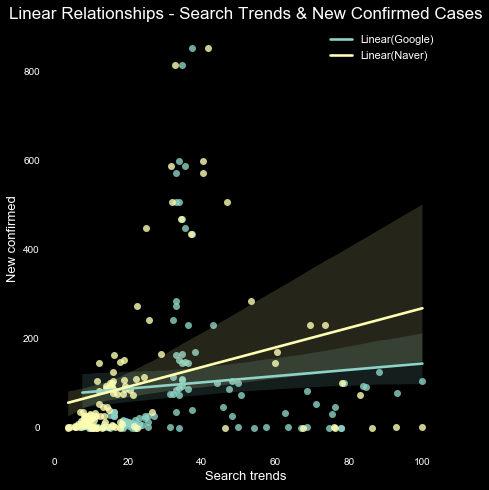

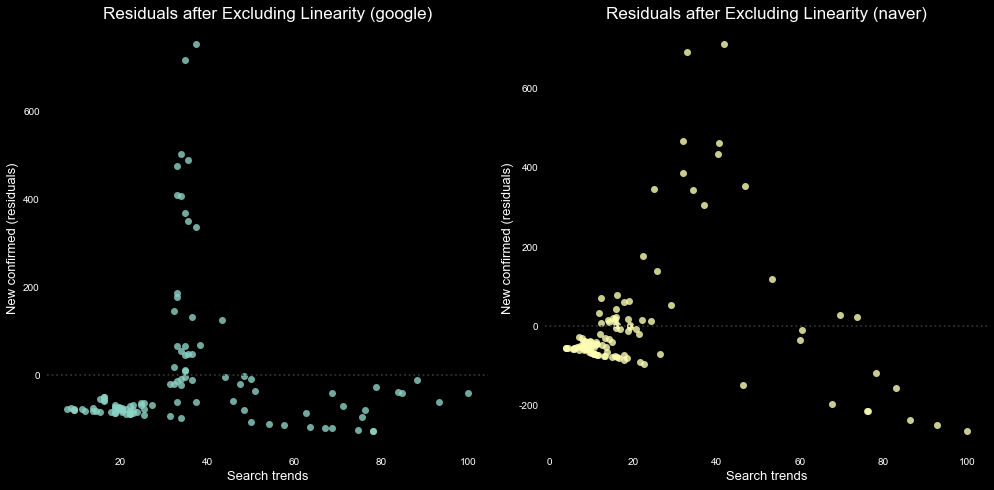

In [48]:
## 1. Linear relationship
# 1) Get time-gaps between search trends and confirmed cases empirically 
gap_google = np.argmax(y) - np.argmax(X_google[:50])
gap_naver = np.argmax(y) - np.argmax(X_naver)
# 2) Plot regressions on scatter points
plt.figure(figsize=(7, 7))
plt.title('Linear Relationships - Search Trends & New Confirmed Cases', size=17)
plt.grid(False)
sns.regplot(X_google[gap_google:len(X_google)]
           , y[:len(X_google)-gap_google])
sns.regplot(X_naver[gap_naver:len(X_naver)]
           , y[:len(X_naver)-gap_naver])
plt.xlabel('Search trends', size=13)
plt.ylabel('New confirmed', size=13)
plt.legend(['Linear(Google)', 'Linear(Naver)'
           ], fontsize=11)
plt.show()

## 2. Residuals - Google
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
axes[0].set_title('Residuals after Excluding Linearity (google)', size=17)
sns.residplot(X_google[gap_google:len(X_google)]
              , y[:len(X_google)-gap_google]
              , ax=axes[0])
axes[0].grid(False)
axes[0].set_xlabel('Search trends', size=13)
axes[0].set_ylabel('New confirmed (residuals)', size=13)
# plt.show()

## 3. Residuals - Naver
plt.title('Residuals after Excluding Linearity (naver)', size=17)
sns.residplot(X_naver[gap_naver:len(X_naver)]
              , y[:len(X_naver)-gap_naver]
              , color=color_list[1]
              , ax=axes[1])
axes[1].grid(False)
axes[1].set_xlabel('Search trends', size=13)
axes[1].set_ylabel('New confirmed (residuals)', size=13)
plt.show()

Snap Analysis - linear relationships / residuals
    1. Naver trends show a stronger positive linearity than Google trends as expected by the similarity of shapes
        - but this result is not definitive since we applied the time gap between the peaks of two graphs for overlapping them better
    2. Both residual plots seem not random (thus not stationary) yet
        - which means a simple linearity can't explain the relationship of search trends and confirmed cases solely
    3. We better run the actual model to check if the search trends have any (limited) potential to predict infections

Linear Regression

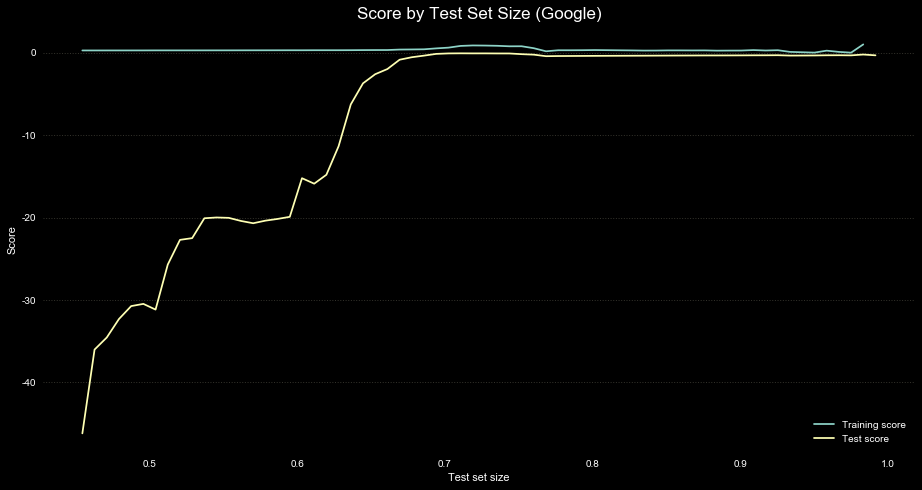

Best training score: 1.0000 (test set size=0.98)
Best test score: -0.0819 (test set size=0.71)


In [49]:
size_range = np.arange(55, len(y))
_, _, pred_g, best_score_g, best_size_g = test_with_range_ts(X_google, y, LinearRegression(), size_range, 'Google');

R2 score on linear regression (applied above and below)
    1. Equation
        R2 = 1 - ( ((truth - prediction)**2).sum() / ((truth - truth.mean())**2).sum() )
    2. Measuring
        How similar the predictions' varaiance from truth is to that of the truth itself
    3. Interpretation
        1 = best fit
        0 = irrelevant predictions
        <0 = worse than random

Result Analysis - score by test set size (Google)
    1. Training score: no clear tendency of improving with more training data
        1) Which is counter-intuitivie at first (as we do expect more data drive better learning)
        2) This is related to the shape of Google trends (a rough bell shape with recent fluctuations)
        3) Only the early parts of it are similar to the truth
            - the middle and latter parts are significantly different
            - thus when the training set contains only the part before diverging, it gives the best score
    2. Test score: too low to get a meaningful insight from
        1) The model learns almost nothing with any size
        2) The test score gets extremely worse when the test set size is less than 70%
Let's check with Naver trends

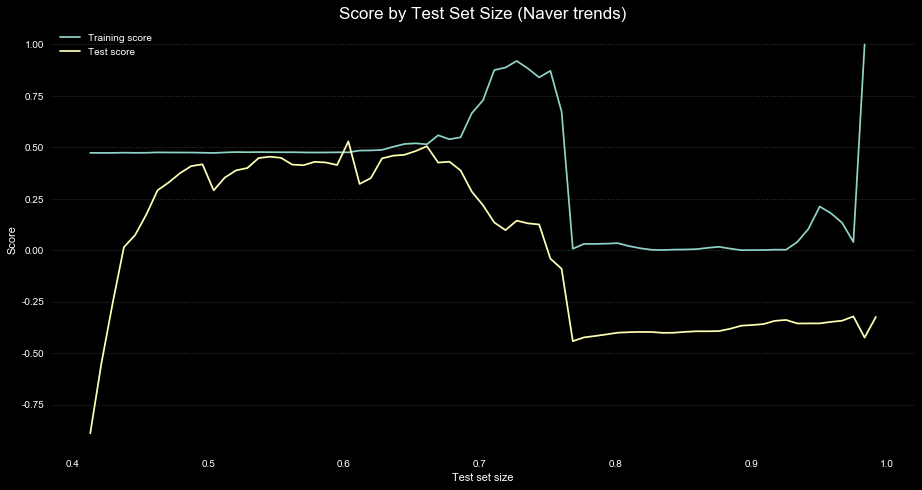

Best training score: 1.0000 (test set size=0.98)
Best test score: 0.5285 (test set size=0.60)


In [50]:
size_range = np.arange(50, len(y))
_, _, pred_n, best_score_n, best_size_n = test_with_range_ts(X_naver, y, LinearRegression(), size_range, 'Naver trends');

Result Analysis - score by test set size (Naver trends)
    1. Training score: similar pattern to that of Google trends
        1) Best score 1 comes with test set size 0.98 (same as Google)
    2. Test score: far better than Google trends
        1) This is expected by the similarity of shapes
        2) The best test set size is about 60% of the data
Let's check the actual predictions with each model's best size

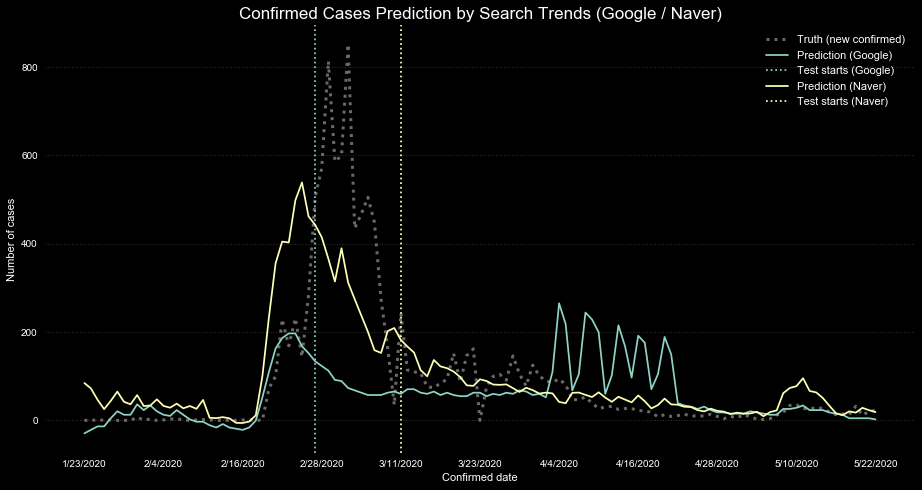

In [51]:
test_start_g, test_start_n = len(search_korea.Day)-best_size_g, len(search_korea.Day)-best_size_n

fig, ax = plt.subplots(figsize=(13, 7))
plt.plot(search_korea.Day, y, color='dimgray'
         , ls=':'
         , lw=3)
plt.plot(search_korea.Day, pred_g)
ax.axvline(search_korea.Day[test_start_g], ls=':', color=color_list[0])
plt.plot(search_korea.Day, pred_n)
ax.axvline(search_korea.Day[test_start_n], ls=':', color=color_list[1])
ax.set_xticks(ax.get_xticks()[::12])
plt.title('Confirmed Cases Prediction by Search Trends (Google / Naver)', size=17)
ax.legend(['Truth (new confirmed)'
           , 'Prediction (Google)'
           , 'Test starts (Google)'
           , 'Prediction (Naver)'
           , 'Test starts (Naver)'
           ], fontsize=11)
plt.xlabel('Confirmed date')
plt.ylabel('Number of cases')
plt.show()

In [52]:
print(f'[R2 score in testing]\nGoogle: %.4f\nNaver: %.4f'
      %(r2_score(y[test_start_g:], pred_g[test_start_g:])
        , r2_score(y[test_start_n:], pred_n[test_start_n:])))

[R2 score in testing]
Google: -0.0819
Naver: 0.5285


Result Analysis - predictions by search trends
    1. Google trends: the recent fluctuations in search trends make the predictions irrelevant
    2. Naver trends: it shows better predictions in test than training
    3. Naver's accuracy heavily relies on the similar shape to the confirmed cases
        - it could be worse if the matching was broken at any point
        - we need a more robust model
Let's use both trends (even if there may be some correlation between them, do at least try)

In [53]:
print('[Sample data] Google + Naver')
X_all = search_korea.iloc[:, -2:]
X_all.head(3).append(X_all.tail(3))

[Sample data] Google + Naver


,naver(all),google(all)
0,19.77503,5.084746
1,17.59853,7.627119
2,13.06011,10.169492
118,9.85471,16.101695
119,8.92189,16.101695
120,8.15162,15.254237


Train / test with the mean of two best sizes

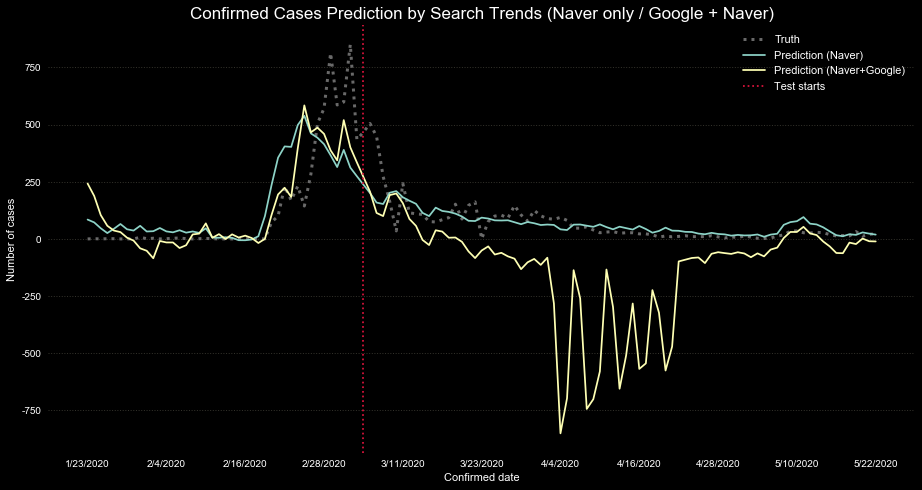

[R2 score in testing]
Naver: 0.5201
Google + Naver: -7.9840


In [54]:
## 1. Split X into train / test sets
best_size = int((best_size_g + best_size_n)/2)
test_start = len(search_korea.Day)-best_size
X_train, y_train, X_test, y_test = X_all.iloc[:test_start, :], y[:test_start], X_all.iloc[test_start:, :], y[test_start:]

## 2. Fit / Predict
lr = LinearRegression()
lr.fit(X_train, y_train)
train_pred = lr.predict(X_train)
test_pred = lr.predict(X_test)
pred_all = np.concatenate([train_pred, test_pred])

## 3. Plot predictions / truths
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Confirmed Cases Prediction by Search Trends (Naver only / Google + Naver)', size=17)
plt.plot(search_korea.Day, y, color='dimgray'
         , ls=':'
         , lw=3)
plt.plot(search_korea.Day, pred_n)
plt.plot(search_korea.Day, pred_all)
ax.axvline(search_korea.Day[test_start], ls=':', color='crimson')
ax.set_xticks(ax.get_xticks()[::12])
ax.legend(['Truth'
           , 'Prediction (Naver)'
           , 'Prediction (Naver+Google)'
           , 'Test starts'
          ], fontsize=11)
plt.xlabel('Confirmed date')
plt.ylabel('Number of cases')
plt.show()

## 4. Check scores
print(f'[R2 score in testing]\nNaver: %.4f\nGoogle + Naver: %.4f'
      %(r2_score(y[test_start:], pred_n[test_start:])
        , r2_score(y[test_start:], pred_all[test_start:])))

Result Analysis
    1. The fluctuations of Google are applied reversely
    2. By this effect, the model gives negative predictions
    3. Negative values are not applicable to daily new confirmed cases
Let's 0-floor the predictions

# All negative predictions converted to 0
Minium value in prediction: 0.0


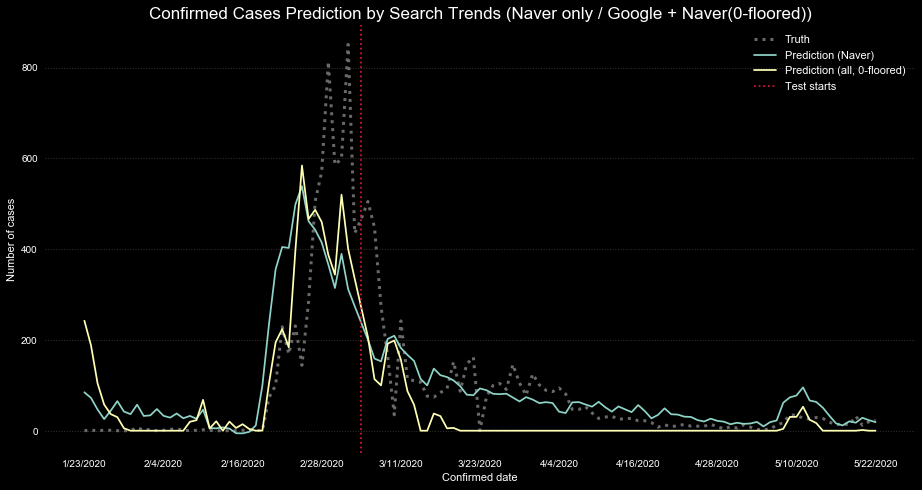

[R2 score in testing]
Naver: 0.5201
Google + Naver(0-floored): 0.2404


In [55]:
## 1. 0-flooring negative predictions
print('# All negative predictions converted to 0')
pred_all[pred_all < 0] = 0
print('Minium value in prediction:', min(pred_all))

## 2. Plot predictions
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Confirmed Cases Prediction by Search Trends (Naver only / Google + Naver(0-floored))', size=17)
plt.plot(search_korea.Day, y, color='dimgray'
         , ls=':'
         , lw=3)
plt.plot(search_korea.Day, pred_n)
plt.plot(search_korea.Day, pred_all)
ax.axvline(search_korea.Day[test_start], ls=':', color='crimson')
ax.set_xticks(ax.get_xticks()[::12])
ax.legend(['Truth'
           , 'Prediction (Naver)'
           , 'Prediction (all, 0-floored)'
           , 'Test starts'
          ], fontsize=11)
plt.xlabel('Confirmed date')
plt.ylabel('Number of cases')
plt.show()

## 3. Check scores
print(f'[R2 score in testing]\nNaver: %.4f\nGoogle + Naver(0-floored): %.4f'
      %(r2_score(y[test_start:], pred_n[test_start:])
        , r2_score(y[test_start:], pred_all[test_start:])))

Result Analysis    
    1. Most predictions in testing turn into 0, with improving the score
    2. But this doesn't solve the problem of poor prediction itself
    3. In conclusion, Naver-only model works best on the data up to now
        - but it's not an actual forecasting yet
        - as the model relies on the given search trends in future days
        - which can't be accessible beforehand in practice (like the daily cases)
We better learn about and apply time series forecasting to use the case value itself as a training set

Time series forecasting - naive / average
    1. naive: the 1 latest observed truth is the next prediction
    2. average: the average of 7 latest observations is the next prediction

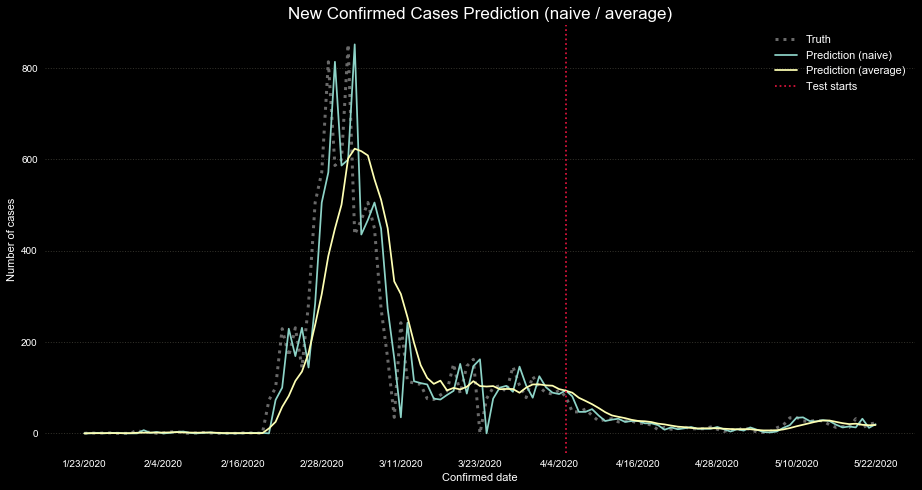

[R2 score in testing]
naive: 0.3252
average: 0.6100


In [56]:
## 0. Reset starting point
best_size = best_size_n
test_start = len(search_korea.Day)-best_size

## 1. Naive
pred_naive = [0] # dynamic all the time
# pred_naive = list(y[:best_size_n]) + list(np.ones(len(y) - best_size_n) * y[best_size_n-1]) # static with the last observation before testing
# pred_naive = list(y[:best_size_n]) + [ y[i-1] for i in np.arange(best_size_n, len(y)) ] # dynamic in testing
[ pred_naive.append(y[i-1]) for i in np.arange(1, len(y)) ]

## 2. Moving average of (up to) 7 latest observations
avg_window = 7
pred_avg_former = [ y[0:i].mean() for i in np.arange(1, avg_window) ]
pred_avg_latter = [ y[i-avg_window:i].mean() for i in np.arange(avg_window, len(y)+1) ]
pred_avg = pred_avg_former + pred_avg_latter

## 3. Plot predictions
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('New Confirmed Cases Prediction (naive / average)', size=17)
plt.plot(search_korea.Day, y, color='dimgray'
         , ls=':'
         , lw=3)
plt.plot(search_korea.Day, pred_naive)
plt.plot(search_korea.Day, pred_avg)
ax.axvline(search_korea.Day[best_size_n], ls=':', color='crimson')
ax.set_xticks(ax.get_xticks()[::12])
ax.legend(['Truth'
           , 'Prediction (naive)'
           , 'Prediction (average)'
           , 'Test starts'
          ], fontsize=11)
plt.xlabel('Confirmed date')
plt.ylabel('Number of cases')
plt.show()

## 4. Check scores
print(f'[R2 score in testing]\nnaive: %.4f\naverage: %.4f'
      %(
          r2_score(y[-best_size_n:], pred_naive[-best_size_n:])
        , r2_score(y[-best_size_n:], pred_avg[-best_size_n:])
       ))

Compare all models

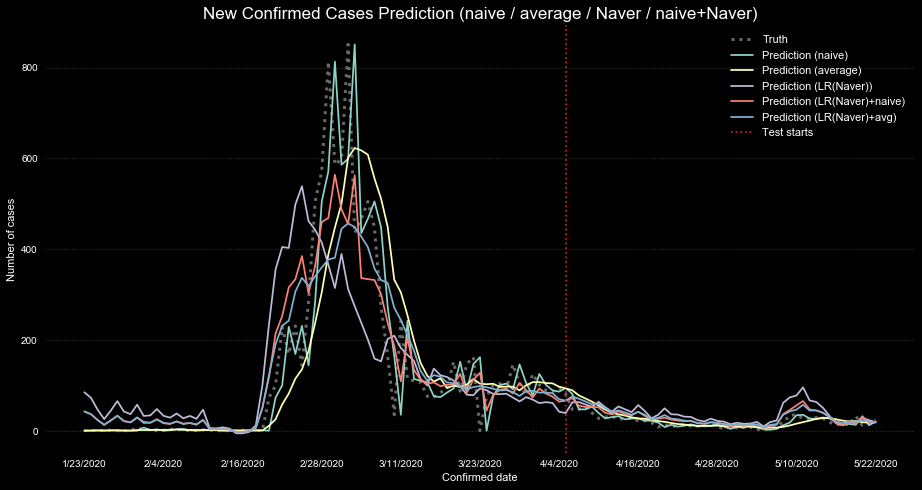

[R2 score in testing]        
Naive: 0.3252        
Average: 0.61        
LR(Naver): 0.5285        
LR(Naver) + Naive: 0.5745        
LR(Naver) + Average: 0.6759


In [57]:
## 1. Naive + linear regression
pred_fusion = (np.array(pred_naive) + np.array(pred_n))/2
pred_fusion_avg = (np.array(pred_avg) + np.array(pred_n))/2

## 2. Compare all predictions
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('New Confirmed Cases Prediction (naive / average / Naver / naive+Naver)', size=17)
plt.plot(search_korea.Day, y, color='dimgray'
         , ls=':'
         , lw=3)
plt.plot(search_korea.Day, pred_naive)
plt.plot(search_korea.Day, pred_avg)
plt.plot(search_korea.Day, pred_n)
plt.plot(search_korea.Day, pred_fusion)
plt.plot(search_korea.Day, pred_fusion_avg)
ax.axvline(search_korea.Day[best_size_n], ls=':', color='crimson')
ax.set_xticks(ax.get_xticks()[::12])
ax.legend(['Truth'
           , 'Prediction (naive)'
           , 'Prediction (average)'
           , 'Prediction (LR(Naver))'
           , 'Prediction (LR(Naver)+naive)'
           , 'Prediction (LR(Naver)+avg)'
           , 'Test starts'
          ], fontsize=11)
plt.xlabel('Confirmed date')
plt.ylabel('Number of cases')
plt.show()

## 3. Check scores
print(f'[R2 score in testing]\
        \nNaive: {round( r2_score(y[-best_size_n:], pred_naive[-best_size_n:]), 4 )}\
        \nAverage: {round( r2_score(y[-best_size_n:], pred_avg[-best_size_n:]), 4 )}\
        \nLR(Naver): {round( r2_score(y[-best_size_n:], pred_n[-best_size_n:]), 4 )}\
        \nLR(Naver) + Naive: {round( r2_score(y[-best_size_n:], pred_fusion[-best_size_n:]), 4 )}\
        \nLR(Naver) + Average: {round( r2_score(y[-best_size_n:], pred_fusion_avg[-best_size_n:]), 4 )}')

## 4. Save the best prediction as a benchmark
bench_korea = pred_fusion_avg

Result Analysis
    1. Average works better than naive
    2. Cause it is less sensitive to the latest change than naive
    3. Linear regression model on Naver search trends shows a comparable score to average's
        - we can get a better score by ensembling both predictions 'LR(Naver) + average'
        - 'LR(Naver) + naive' also shows a performance gain but not as big as that with average
Could we validate this result with the data of other countries?

[Germany] a country with reasonably larger values of variables than S.Korea
    1. Population - Germany: 83,149,300 / S.Korea: 51,780,579
    2. Confirmed rate - Germany: 2,198 / S.Korea: 226 (per 1 million people)
    3. Google market share - Germany: 92.86% / S.Korea: 76.52%
- reference:
[German population (2019-09-30)](https://www.destatis.de/DE/Themen/Gesellschaft-Umwelt/Bevoelkerung/Bevoelkerungsstand/Tabellen/zensus-geschlecht-staatsangehoerigkeit-2019.html) / 
[Confirmed rate (2020-06-02)](https://www.worldometers.info/coronavirus/) / 
[German Market share (2020-05)](https://gs.statcounter.com/search-engine-market-share/all/germany)

In [59]:
## 1. Get data
search_germany = pd.read_csv('./search/search_germany.csv')
## 2. Cleanse nulls and insignificant values
search_germany = search_germany.dropna()
search_germany = search_germany.replace('<1', 0) # <1 means less than 1 significance in raw data
## 3. Convert object to float
search_germany.iloc[:, 1:-2] = search_germany.iloc[:, 1:-2].astype(float)
## 4. Get a new column by merging 5 sub-columns for COVID-19 search on Google
search_germany['google(all)'] = search_germany.iloc[:, 1:-1].sum(axis=1)
search_germany['google(all)'] = search_germany['google(all)']/max(search_germany['google(all)']) * 100 # normalizing

search_all = search_germany[:len(test_raw)] # match lengths with test_raw

print('[Search Trends in Germany - sample]')
search_germany.head(3).append(search_germany.tail(3))

[Search Trends in Germany - sample]


,Day,corona: (Germany),coronavirus: (Germany),covid19: (Germany),covid: (Germany),google(all)
0,1/27/2020,2.0,6.0,0,0,5.479452
1,1/28/2020,4.0,14.0,0,0,12.328767
2,1/29/2020,3.0,11.0,0,0,9.589041
114,5/20/2020,23.0,4.0,0,1,18.493151
115,5/21/2020,22.0,5.0,0,1,18.493151
116,5/22/2020,20.0,4.0,0,1,16.438356


- reference: [Google trends](https://trends.google.com/trends/explore?date=2020-01-20%202020-05-25&geo=DE&q=corona,coronavirus,covid19,covid) (2020-05-25)

In [60]:
## 1. Pick relevant rows and columns from test_global
daily_germany_raw = test_global[ (test_global.Country_Region=='Germany') 
                                & (test_global.Target=='ConfirmedCases') 
                                & (test_global.Date>='2020-01-27') 
                               ].loc[ :, ['Date', 'TargetValue'] ]
print('[Daily confirmed cases in Germany - sample]')
if len(search_germany) < len(daily_germany_raw):
    daily_germany = daily_germany_raw[:len(search_germany)]
else:
    daily_germany = daily_germany_raw
    search_germany = search_germany[:len(daily_germany)]

## 2. Check result
display(daily_germany.head(3).append(daily_germany.tail(3)))
data_range(daily_germany, 'Date')

## 3. Get X, y
X_germany, y_germany = search_germany['google(all)'], daily_germany.TargetValue.values
# X_germany, y_germany = np.log(X_germany+1), np.log(y_germany+1) # log version

[Daily confirmed cases in Germany - sample]


,Date,TargetValue
35378,2020-01-27,1.0
35380,2020-01-28,3.0
35382,2020-01-29,0.0
35606,2020-05-20,695.0
35608,2020-05-21,548.0
35610,2020-05-22,689.0


Date range: 117 days
# 2020-01-27 to 2020-05-22


- reference: [COVID19 Global Forecasting (Week 5) challenge](https://www.kaggle.com/c/covid19-global-forecasting-week-5/data)

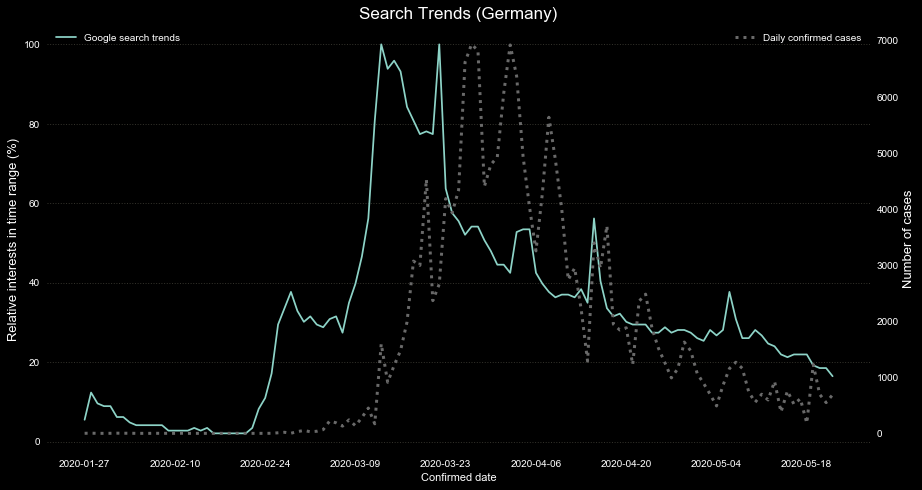

In [61]:
fig, ax1 = plt.subplots(figsize=(13, 7))
plt.title('Search Trends (Germany)', size=17)
ax1.plot(daily_germany.Date
         , X_germany)
#          , np.log(search_germany.iloc[:,-1])+1) # log version
ax1.set_xticks(ax1.get_xticks()[::14])
ax1.legend(['Google search trends']
           , loc='upper left')
ax1.set_xlabel('Confirmed date')
ax1.set_ylabel('Relative interests in time range (%)', size=13)

ax2 = ax1.twinx()
ax2.grid(False)
ax2.plot(daily_germany.Date
         , y_germany
#          , np.log(daily_germany.TargetValue+1) # log version
         , color='dimgray'
         , ls=':'
         , lw=3)         
ax2.set_xticks(ax2.get_xticks()[::14])
ax2.legend(['Daily confirmed cases']
           , loc='upper right')
ax2.set_ylabel('Number of cases', size=13)
plt.show()

Snap Analysis
    1. The peaks of search trends are prior to that of daily cases with about 2 weeks of interval
    2. This showed in the graph for S.Korea too with a shorter interval (1 week)
    3. Not only the global shape but also the small spikes have the similarity to the truth
        - e.g. around 2020-02-29, 2020-03-21, 2020-04-05
Let's apply linear regression and naive/average forecasting

Linear regression with Google search trends

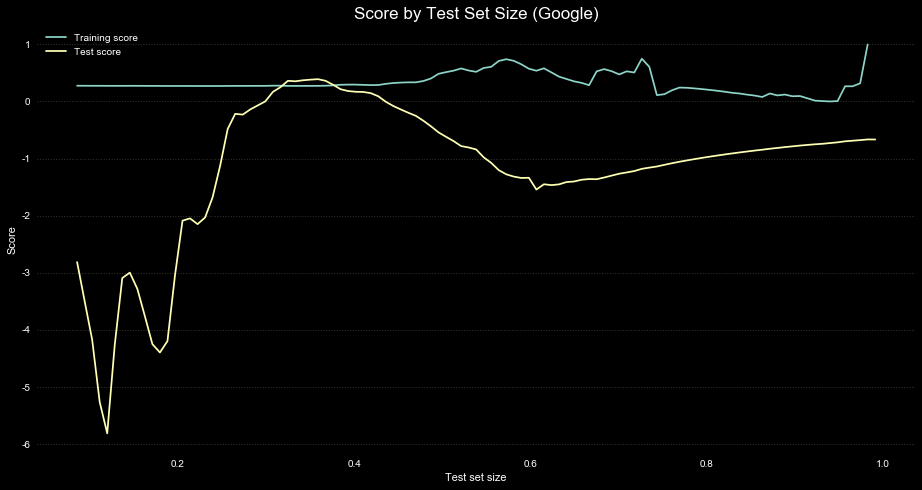

Best training score: 1.0000 (test set size=0.98)
Best test score: 0.3906 (test set size=0.36)


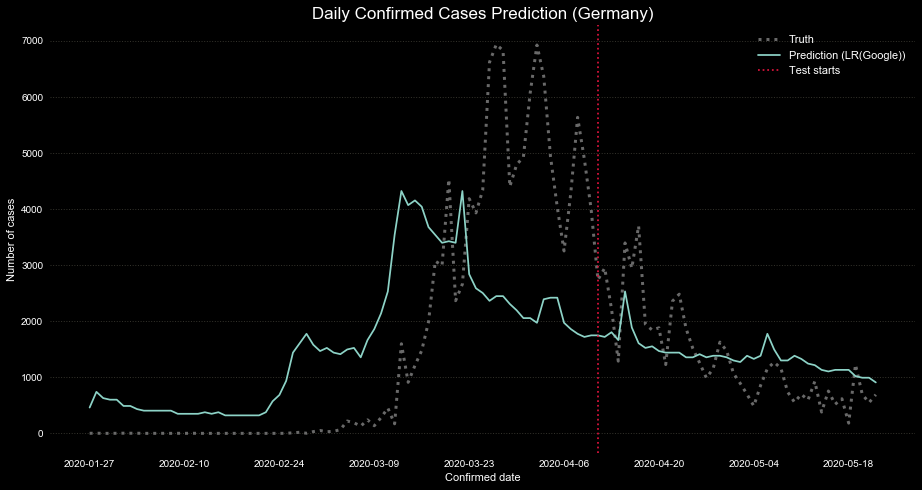

[R2 score in testing]
LR(Google): 0.3906


In [62]:
## 1. Find the best size
size_range = np.arange(10, len(y_germany))
_, _, pred_g, best_score_g, best_size_g = test_with_range_ts(X_germany, y_germany, LinearRegression(), size_range, 'Google');

## 2. Split / fit / predict
# 1) Split
X_train, y_train, X_test, y_test = np.array(X_germany[:-best_size_g]), y_germany[:-best_size_g], np.array(X_germany[-best_size_g:]), y_germany[-best_size_g:]
X_train, X_test = X_train.reshape(-1, 1), X_test.reshape(-1, 1)
# 2) Fit / Predict
lr = LinearRegression()
lr.fit(X_train, y_train)
train_pred = lr.predict(X_train)
test_pred = lr.predict(X_test)
pred_all = np.concatenate([train_pred, test_pred])
# 3) Plot predictions
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Daily Confirmed Cases Prediction (Germany)', size=17)
plt.plot(daily_germany.Date, y_germany, color='dimgray'
         , ls=':'
         , lw=3)
plt.plot(daily_germany.Date, pred_all)
ax.axvline(daily_germany.Date.iloc[-best_size_g], ls=':', color='crimson')
ax.set_xticks(ax.get_xticks()[::14])
ax.legend(['Truth'
           , 'Prediction (LR(Google))'
           , 'Test starts'
          ], fontsize=11)
plt.xlabel('Confirmed date')
plt.ylabel('Number of cases')
plt.show()

## 3. Check score
print(f'[R2 score in testing]\nLR(Google): %.4f'
      %(
          r2_score(y_germany[-best_size_g:], pred_all[-best_size_g:])
       ))

Naive / average forecasting with daily confirmed cases

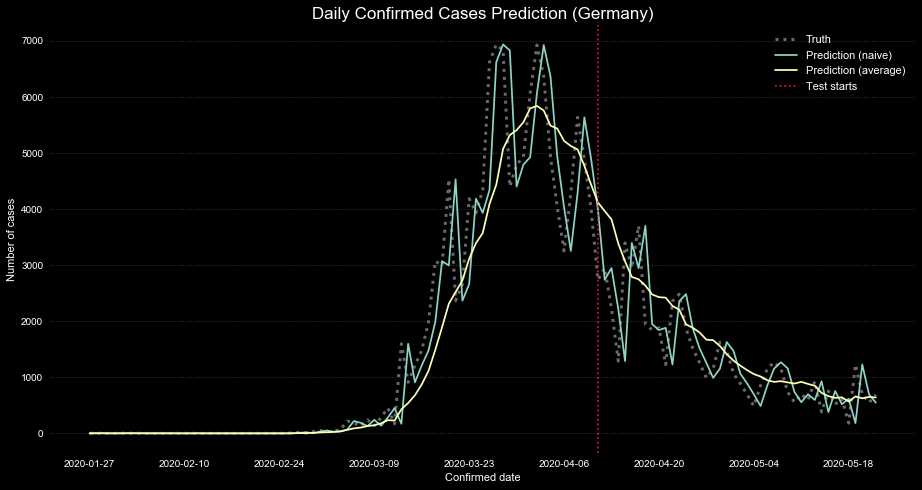

[R2 score in testing]
Naive: 0.4464
Average: 0.4580


In [63]:
## 1. Dynamic naive
pred_naive = [0]
[ pred_naive.append(y_germany[i-1]) for i in np.arange(1, len(y_germany)) ]

## 2. Moving average of (up to) 7 latest observations
pred_avg_former = [ y_germany[0:i].mean() for i in np.arange(1, avg_window) ]
pred_avg_latter = [ y_germany[i-avg_window:i].mean() for i in np.arange(avg_window, len(y_germany)+1) ]
pred_avg = pred_avg_former + pred_avg_latter

## 3. Fusioned versions
pred_fusion_germany = (np.array(pred_naive) + np.array(pred_all))/2
pred_fusion_germany_avg = (np.array(pred_avg) + np.array(pred_all))/2

## 4. Plot predictions
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Daily Confirmed Cases Prediction (Germany)', size=17)
plt.plot(daily_germany.Date, y_germany, color='dimgray'
         , ls=':'
         , lw=3)
plt.plot(daily_germany.Date, pred_naive)
plt.plot(daily_germany.Date, pred_avg)
ax.axvline(daily_germany.Date.iloc[-best_size_g], ls=':', color='crimson')
ax.set_xticks(ax.get_xticks()[::14])
ax.legend(['Truth'
           , 'Prediction (naive)'
           , 'Prediction (average)'
           , 'Test starts'
          ], fontsize=11)
plt.xlabel('Confirmed date')
plt.ylabel('Number of cases')
plt.show()

## 5. Check score
print(f'[R2 score in testing]\nNaive: %.4f\nAverage: %.4f'
      %(
          r2_score(y_germany[-best_size_g:], pred_naive[-best_size_g:])
          , r2_score(y_germany[-best_size_g:], pred_avg[-best_size_g:])
       ))

Compare all models

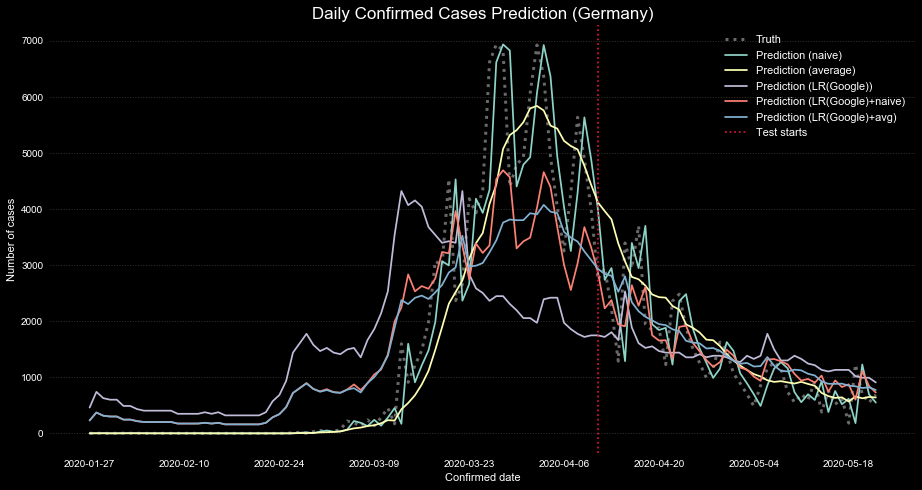

[R2 score in testing]        
Naive: 0.4464        
Average: 0.458        
LR(Google): 0.3906        
LR(Google) + Naive: 0.6453        
LR(Google) + Average: 0.6709


In [64]:
## 1. Plot predictions with all models
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Daily Confirmed Cases Prediction (Germany)', size=17)
plt.plot(daily_germany.Date, y_germany, color='dimgray'
         , ls=':'
         , lw=3)
plt.plot(daily_germany.Date, pred_naive)
plt.plot(daily_germany.Date, pred_avg)
plt.plot(daily_germany.Date, pred_all)
plt.plot(daily_germany.Date, pred_fusion_germany)
plt.plot(daily_germany.Date, pred_fusion_germany_avg)
ax.axvline(daily_germany.Date.iloc[-best_size_g], ls=':', color='crimson')
ax.set_xticks(ax.get_xticks()[::14])
ax.legend(['Truth'
           , 'Prediction (naive)'
           , 'Prediction (average)'
           , 'Prediction (LR(Google))'
           , 'Prediction (LR(Google)+naive)'
           , 'Prediction (LR(Google)+avg)'
           , 'Test starts'
          ], fontsize=11)
plt.xlabel('Confirmed date')
plt.ylabel('Number of cases')
plt.show()

## 2. Check scores
print(f'[R2 score in testing]\
        \nNaive: {round( r2_score(y_germany[-best_size_g:], pred_naive[-best_size_g:]), 4 )}\
        \nAverage: {round( r2_score(y_germany[-best_size_g:], pred_avg[-best_size_g:]), 4 )}\
        \nLR(Google): {round( r2_score(y_germany[-best_size_g:], pred_all[-best_size_g:]), 4 )}\
        \nLR(Google) + Naive: {round( r2_score(y_germany[-best_size_g:], pred_fusion_germany[-best_size_g:]), 4 )}\
        \nLR(Google) + Average: {round( r2_score(y_germany[-best_size_g:], pred_fusion_germany_avg[-best_size_g:]), 4 )}')

## 3. Save the best prediction as a benchmark
bench_germany = pred_fusion_germany_avg

Performance Analysis - daily confirmed cases prediction (Germany)
    1. Naive VS. average
        1) Naive wins when there's little difference between days
        2) Averaging is more robust for the short-term shifts
            - the robustness depends on the window size of averaging (7 applied now)
        3) This shows in the case of ensembling with other models too
    2. Linear regression on Google search trends works better in test than training (same as S.Korea)
        1) Only the scale is alterable while the shape is stable
        2) The degree of change is up to the choice of testset size
            - which we decided by empirical runnings with various test set sizes
            - this could make the model overfitted only to the test set we have now
        3) We need a complementary model which is insensitive to test set sizes
    3. Average / naive forecasting complement the regression model as they are running dynamically
        1) Linear regression could harness all the observations in the training set
        2) Average forecasting is more dynamic than linear regression as it learns from only the recent truths
        3) Naive catches more dynamic change than average (1 observation VS. 7 observations)
            - but this could be hurting the performance when there is a continuous shifting like in Germany

What about using more sophisticated forecasting methods? (on the data of S.Korea)

<a id='fc_arima_basics'></a>
> # [[FC]](#table) 2.1 ARIMA - basics
ARIMA - A statistical model for time series forecasting (AutoRegressive + Integrated + Moving Average)
    1. AR (autoregressive): checks and uses the dependent relationship between the truth and the lagged value of it
    2. I (integrated): subtracts previous values from the truth to make the time series stationary
        - stationary means the values are random without trend, seasonal or cyclic patterns
    3. MA (moving average): uses the moving average of residual errors for forecasting future values
        - similar to moving average of truth values above but focusing on residual errors
- reference
    1. [Forecasting: Principles and Practice - Chapter 8 ARIMA models](https://otexts.com/fpp2/arima.html)
    2. [How to Create an ARIMA Model for Time Series Forecasting in Python](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/)

In [ ]:
acplot(daily_korea.TargetValue)
plt.title('Autocorrelation of daily confrimed cases (S.Korea)', size=17)
plt.xlabel('Lag size', size=13)
plt.ylabel('Autocorrelation', size=13)
plt.show()

Snap Analysis - autocorrelation of daily confirmed cases (S.Korea)
    1. The values show significant correlations with the truth up to 10 lag
        - which means the lagged (previous) values of the truth could be useful
    2. We choose 10 lag as the parameter of p(AR part) in ARIMA model
    3. Lag 38 almost reaches the significance threshold with 99% confidence
        - but not with 95%, thus we won't use it

In [ ]:
## 1. Fit the model with 10 lags for AR(autoregression) and 1 window for I(difference)
p, d, q = 10, 1, 0
date_list = daily_korea.Date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
arima = ARIMA(daily_korea.TargetValue
              , dates= date_list
              , order=(p, d, q)
              , freq="D").fit()
print(f'# ARIMA model fitted\n[Parameters]\np(AR part): {p}, d(I part): {d}, q(MA part): {q}')

## 2. Print the result report
# print(arima.summary()) 

## 3. Check residual errors
fig, ax = plt.subplots(figsize=(13, 7))
plt.plot(daily_korea.Date, arima.resid)
plt.title('Residual Errors of ARIMA on Daily Confrimed Cases (S.Korea)', size=17)
plt.xlabel('Date', size=13)
plt.ylabel('Residual errors', size=13)
ax.set_xticks(ax.get_xticks()[::15])
plt.show()

Snap Analysis - residual errors of ARIMA on daily confirmed cases    
    1. The errors shows a random spread around 0 line
    2. Yet it seems there is some left information the model can use but not extracted
    3. Especially around 2020-02-29 (near to the peak of the truth) could have it

In [ ]:
## 1. Check distribution of residual errors
arima.resid.plot(kind='kde'
                 , grid=False)
plt.title('Residual Errors Distribution', size=17)
plt.xlabel('Residual Errors', size=13)
plt.ylabel('Density', size=13)
plt.show()
## 2. Check statistics
print('[Basic statistics]')
print(arima.resid.describe())

- Residual errors seem normally distributed, with 0 mean

Let's check the actual predictions

In [ ]:
## 1. Overlap predictions(+1 step to the last observation) onto the truth
fig, ax = plt.subplots(figsize=(13, 7))

plt.plot(daily_korea.Date
         , daily_korea.TargetValue
         , color='#33322B', ls=':' , lw=3)
plt.plot(daily_korea.Date[:-1]
        , arima.predict()[1:])
plt.title('ARIMA (one-step forecasting for every date)', size=17)
plt.xlabel('Date', size=13)
plt.ylabel('Number of cases', size=13)
ax.set_xticks(ax.get_xticks()[::15])
plt.legend(['Truth', 'Prediction', 'Test starts'], loc='upper left')
plt.show()

## 2. Check scores
diff, rmse, mae, mape = diff_metrics(daily_korea.TargetValue[:-1], arima.predict()[1:])
scores = pd.DataFrame(
    {'rmse': rmse
     , 'mae': mae
     , 'mape': mape}
    , index=['score']
)
scores

Result Analysis - ARIMA (one-step forecasting for every date)
    1. ARIMA model gives one-step prediction for every date
    2. We apply -1 step to all predictions to overlap them with the truth
    3. The model fits the truth quite well visually and numerically
Can't it do better? Let's grid search better parameters

In [ ]:
p, d, q = 10, 1, 0
param_list, mape_list = arima_grid(daily_korea, p, d, q, 1);
print(f'Minium MAPE: {round(min(mape_list), 4)} by {combi_list[np.argmin(mape_list)]} (p, d, q)')

In [ ]:
## 1. Apply best parameter set
arima = ARIMA(daily_korea.TargetValue
              , dates=date_list
              , order=(11, 2, 0)
              , freq="D").fit()
arima_pred = arima.predict()

## 2. Overlap predictions(+1 step to the last observation) onto the truth
fig, ax = plt.subplots(figsize=(13, 7))

plt.plot(daily_korea.Date
         , daily_korea.TargetValue
         , color='#33322B', ls=':' , lw=3)
plt.plot(daily_korea.Date[:-1]
        , arima.predict()[1:])
plt.title('ARIMA (one-step forecasting for every date)', size=17)
plt.xlabel('Date', size=13)
plt.ylabel('Number of cases', size=13)
ax.set_xticks(ax.get_xticks()[::15])
plt.legend(['Truth', 'Prediction', 'Test starts'], loc='upper left')
plt.show()

## 3. Check scores
diff, rmse, mae, mape = diff_metrics(daily_korea.TargetValue[:-1], arima.predict()[1:])
scores = pd.DataFrame(
    {'rmse': rmse
     , 'mae': mae
     , 'mape': mape}
    , index=['score']
)
scores

Result Analysis - ARIMA with better parameters
    1. We got a 13.17% performance gain (MAPE: from 0.687032 to 0.59652)
    2. Visaul fitting, RMSE, and MAE also show better results
    3. But this could lead overfitting
Let's try multi-step forecasting with ARIMA

In [ ]:
## dev log - 7th Jun 2020 Sun 01:04

<a id='fc_prophet_basics'></a>
> # [[FC]](#table) 3.1 Prophet - basics

Prophet (or fbprophet)
    1. A semi-automated forecasting library open-sourced by Facebook in 2017
    2. Focusing to automate
        1) forecasting
        2) evaluating the results
    3. While freeing human analysts for
        1) designing the model with a simpler parameter tuning (than non-automated alternatives)
        2) getting into the loop for improvement, only if necessary after inspecting the results
- reference: [Prophet github page](https://facebook.github.io/prophet/)

Let's start with default settings

In [43]:
pp_daily, predict_daily = do_prophet(daily_korea[:shorter_len], 'Date', 'TargetValue' # dataframe, columns for date and y
                                     , test_size=best_size_n # set forecasting horizon
                                     , is_bench=True # plot a given model's predictions too
                                     , benchmark=bench_korea, bm_name='LR(Naver) + average'
                                     , simple=False # skip printing intermetidate outputs
                                    )

NameError: name 'daily_korea' is not defined

In [ ]:
print('[Plot by Prophet built-in function]')
plt.style.use('seaborn')
pp_daily.plot(predict_daily)
plt.show()
print('# dakrer blue line = point forecasting (yhat)\
        \n# lighter blue area = 80% uncertainty interval (yhat_lower ~ yhat_upper)')

print('\n[Detailed plots by Prophet built-in function]')
plt.style.use('seaborn')
pp_daily.plot_components(predict_daily) # detailed plots (trend, seasonality)
plt.show()
print('# trend = global trend\
        \n# weekly = weekly seasonality')

Result Analysis - Prohet with default parameters (test_size=best_size_n)
    1. The model catches the early trend of increasing while missing the late trend of decreasing
        - even though the downhill is also included in the training set, Prophet didn't catch it
    2. It shows the ability to grasp a weekly seasonality by itself (we didn't notice this above)
    3. But the seasonality isn't able to turn down the global curve after the peak
        - this auto-caught weekly seasonality might be the cause of the mismatching in trends
What about using a custom season size?

In [ ]:
## Reset plot style
set_style()

Prophet with a custom season size (training set size)

In [ ]:
pp_daily, predict_daily = do_prophet(daily_korea[:shorter_len], 'Date', 'TargetValue'
                                     , test_size=best_size_n
                                     , is_bench=True
                                     , benchmark=bench_korea, bm_name='LR(Naver) + average'
                                     , simple=True
                                     , custom_period=True, period=len(daily_korea)-best_size_n
                                    )

Result Analysis - Prophet with a custom season size (training set size)
    1. The model learns the global shape of the training part
    2. It seems merely to copy and paste the same shape for forecasting
        - with weakening values by judging the trend is decreasing
    3. This is a wrong assumption regarding that training set hasn't finished 1 cycle yet
We need at least 1 full cycle for training

Prophet on one-step forecasting (daily cases)
    - Training set: all data except for 1 last observation
    - Test set: the last observation

In [ ]:
pp_1step, predict_1step = do_prophet(daily_korea[:shorter_len], 'Date', 'TargetValue' # dataframe, columns for date and y
                                     , test_size=1 # set forecasting horizon
                                     , is_bench=True # plot a given model's predictions too
                                     , benchmark=bench_korea, bm_name='LR(Naver) + average'
                                     , simple=True # skip printing intermetidate outputs
                                     , custom_period=True, period=shorter_len-1, num_curve=5
                                    )

In [ ]:
date = daily_korea.Date.values[shorter_len]
truth = daily_korea.iloc[shorter_len, -1]
pred = predict_1step.yhat.values[-1]
diff = pred - truth
result_1step = result_df(date, truth, pred)
print('[Prediction - Prophet]')
display(result_1step)
result_bench = result_df(date, truth, bench_korea[-1])
print('[Prediction - benchmark]')
display(result_bench)

Result Analysis - Prophet on one-step forecasting (daily cases)
    1. Prophet works worse than our best model (linear regression on Naver search + average forecasting)
        - Differences from truth: 28.56 to 6.44 (Prophet to benchmark)
    2. The shape is a lot smoother than the benchmark and truth (including some negative values)
    3. What about using cumulative confirmed cases than daily new cases as target values?
        - they show a clear logistic growth curve which seems more stable than daily up and down

Prophet on one-step forecasting (cumulative cases)

In [ ]:
pp_cumulative, predict_cumulative = do_prophet(test_raw, 'date', 'confirmed'
                                               , test_size=1 , is_bench=False
                                               , custom_period=True, period=shorter_len-1
                                              )

In [ ]:
date = test_raw.date.values[-1]
truth = test_raw.loc[len(test_raw)-1, 'confirmed']
pred = predict_cumulative.yhat.values[-1]
diff = pred - truth

result_1step = result_df(date, truth, pred)
result_1step

Result Analysis - Prophet on one-step forecasting (cumulative cases)
    1. The model fitted the truth better than daily cases in a visual manner
    2. But the numeric score is worse than that of daily cases
        - Differences from truth: 84.25 to 28.56 (cumulative to daily)
        - This might come from the bigger absolute numbers of cumulative cases
    3. We better focuse on improving the model with daily cases
        - because the two differeces in two data direct the same figure related to the truth
        - which is the number of over/under-estimated confirmed cases per day
What about experimenting with various test set sizes (forecasting horizons) more systematically?

Cross validation with Prophet built-in function
    1. Prophet offers an automated model evaluation function
    2. The main parameter is the upper limit of forecasting horizon (N)
    3. Prophet runs with 1 to N horizon to get a score on each horizon (n)

In [ ]:
## 1. Set parameters
pp_list = [pp_1step, pp_cumulative]
horizon = 5
initial = len(predict_1step) - horizon - int(horizon/2)
## 2-1. Corss validate for the model on daily cases
pp_cv = cross_validation(pp_1step
                         , horizon= f'{horizon} days'
                         , initial=f'{initial} days')
print('[Performance Metrics - daily cases]')
pp_pm = performance_metrics(pp_cv)
display(pp_pm
#         .tail(3)
       )
print('- MSE: Mean Sqaure Error\
    \n- RMSE: Root Mean Sqaure Error\
    \n- MAE: Mean Absolute Error\
    \n- MAPE: Mean Absolute Percentage Error\
    \n- MdAPE: Median Absolute Percentage Error\
      ')
plt.style.use('seaborn')
print('\n[Score(MAPE) by length of the forecasting horizon - daily cases]')
plot_cross_validation_metric(pp_cv
                             , metric='mape')
plt.show()

## 2-2. Corss validate for the model on cumulative cases
initial = len(predict_cumulative) - horizon - int(horizon/2)
pp_cv_cumul = cross_validation(pp_cumulative
                               , horizon= f'{horizon} days'
                               , initial=f'{initial} days')
print('\n[Score(MAPE) by length of the forecasting horizon - cumulative cases]')
plot_cross_validation_metric(pp_cv_cumul
                             , metric='mape')
plt.show()

Result Analysis
    1. The longer the horizon, the less accurate the model in general
    2. It's the innate limitation of our model which learned from utmost 1 cycle of infections
        1) It assumes the season must be repeated with the start of forecasting (like ARIMA)
            - which means it is not just the limit of our model but also the basic assumption of major forecasting methods
        2) But this assumption can be wrong when there's no more waves of infections
            - the preformance would be poor too, even if there are more cycles
              but they aren't of the same size and pattern to the first one
        3) In short, our dataset isn't proper for forcasting our own cases in the future
    3. But it could be useful for those who are in the early or middle of the first wave yet for learning what's coming
        1) S.Korea has only 1 cycle (most other countries do as well)
        2) It must be not enough to generalize to others
        3) We need more data
            - not from the future of one country
            - but from the present of many countries
Let's convert the similarity in space to the seasonality in time
- by merging the cases of numerous countries into 1 long artificial time series

In [ ]:
set_style()

<a id='fc_prophet_fit'></a>
> # [[FC]](#table) 3.2 Prophet - space to time

In [ ]:
print('[Sample data]')
display(test_global.head(3).append(test_global.tail(3)).T)

Data structure - test_global (sample)

In [ ]:
row_by_country = pd.DataFrame({'number_of_rows': test_global.Country_Region.value_counts().values
                               , 'number_of_(sub)regions': map(int, test_global.Country_Region.value_counts().values/min(test_global.Country_Region.value_counts().values))}
                              , index=test_global.Country_Region.value_counts().index)
row_by_country.head(3).append(row_by_country.tail(3))

Data structure - a new time seires
    1. There are 187 countries in test_global with different numbers of rows by subregion
        - 1 to 3198 subregions (1 subregion means it has no subregion than the country itself)
    2. We will group them country-wide
    3. And use 'Date, TargetValue' columns to make a time series data

Cleanse and preprocess data

In [ ]:
## 1. Get only rows with confirmed cases (excluding fatalities)
test_global_confirmed = test_global[ test_global.Target == 'ConfirmedCases' ]
print(f'# Only rows with confirmed cases selected (excluding fatalities)')
## 2. Check null
print(f'Number of nulls: {test_global_confirmed.TargetValue.isna().sum()}')
## 3. Replace negative values with the previous value (empirically checked there's no successive negative values)
neg_rows = test_global_confirmed[ test_global_confirmed.TargetValue < 0 ]
print(f'Number of negative values: {len(neg_rows)}')
for i in neg_rows.index:
    test_global_confirmed.loc[i, 'TargetValue'] = test_global_confirmed.loc[i-2, 'TargetValue']
print(f'# {len(neg_rows)} negative values are replaced with the previous ones')
print(f'Number of negative values after replacing: {len(test_global_confirmed[ test_global_confirmed.TargetValue < 0 ])}')

Selection criterion
    1. We need a criterion to choose which countries to learn from before making a time series data
    2. We defined it as recent_to_max ratio for grasping the infection phase in which a country is
    3. Equation: recent_daily_confirmed.mean() / max_daily_confirmed = recent_to_max (of a country)
        1) e.g. ((35+38+49)/3) / 851 = 0.0478 (S.Korea)
        2) recent_to_max = 1, if max_daily_confirmed is one of the values in recent_window
    4. Reasoning behind recent_window (number of days to be considered as "recent")
        1) default = 3
            - To catch the latest trend of increasing
        2) only 1 recent window is too sensitive to daily up and down
        3) longer than 7 window is good at catching the countries having passed 1 cycle already
            - the longer, the surer the country with low ratios is not in the first wave anymore
            - but terrible in differntiating the countries with high ratios (in the early phase)

Infection phase by country - order by confirmed cases

In [ ]:
print('[Sample data]')
recent_window = 3
test_global_all, data_grouped = get_recent_to_max(test_global_confirmed, recent_window = recent_window)
display(test_global_all.head(3).append(test_global_all.tail(3)))
print('[Basic statistics]')
test_global_all.describe()

Snap Analysis - infection phase by country
    1. The more cases, the higher recent_to_max ratio broadly
        - countries with 3 most cases VS. countries with 3 least cases
    2. But this doesn't fit for all individual cases
        - US shows a lower ratio than Brazil, although it has more cases
    3. More than 50% countries show less than 0.2 ratio of recent_to_max
        - they assumed to be in the phase of slowing down or containing infections
Let's see if there's a similarity in the curves among the countries with the similar ratio

Infection phase by country - order by recent_to_max (lowest to highest)

In [ ]:
min_cases = 2000
test_global_recent = test_global_all[test_global_all.total_cases >= min_cases].sort_values('recent_to_max')
print(f'# countries with less than {min_cases} total cases excluded')
print('Number of countries left:', len(test_global_recent))

Three countries with the lowest ratio

In [ ]:
plot_phase(data_grouped, test_global_recent)

Three countries with the highest ratio

In [ ]:
plot_phase(data_grouped, test_global_recent, reverse=True)

###### Click "output" to see all plots for all countries (lowest to highest ratio)

In [ ]:
if not fast:
    plot_phase(data_grouped, test_global_recent, no_of_country=len(test_global_recent))

Snap Analysis - different phase by country
    1. The larger the ratio, the earlier the phase of spreading
    2. The countries with <0.2 ratio seem in the later phase
    3. With 0.1 ratio, we can assume that a country is at the end of 1 full cycle or have passed it
Let's experiment with countries with <0.1 ratio

In [ ]:
cluster_full = test_global_recent[ test_global_recent .recent_to_max < 0.1 ]
cluster_full = cluster_full.sort_values('recent_to_max')
print('[First/last countries in the cluster with 1 full cycle]')
display(cluster_full.head(1).append(cluster_full.tail(1)))
print('Number of countries included: ', len(cluster_full))

In [ ]:
## 1. Make a new dataframe / fill it with daily confirmed cases (scaled to max of each country)
full_df_raw = pd.DataFrame()
for i in cluster_full.index:
    temp = test_global_confirmed[test_global_confirmed.Country_Region == i].groupby('Date').sum()
    full_df_raw = pd.concat([full_df_raw, temp.TargetValue/max(temp.TargetValue)*100])
full_df = full_df_raw.rename(columns={0: 'confirmed_scaled'})

## 2. Set artificial historical dates to convert the similarity in space into the seasonality in time
date_range = np.arange(\
                       # first date
                       datetime.strptime(full_df.index[-1], '%Y-%m-%d').date() - timedelta(days=len(full_df)-1)
                       # last date
                       , datetime.strptime(full_df.index[-1], '%Y-%m-%d').date() + timedelta(days=1)
                      )
full_df.index = range(len(full_df))
full_df['date'] = date_range
full_df = full_df[['date', 'confirmed_scaled']]
print('[Sample data - vectorized / scaled]')
display(full_df.head(3).append(full_df.tail(3)))
# artificial season size = numbers of days in a country in test_global
days_of_country = len(data_grouped.get_group('Germany'))
print(f'# vectorized: convert a country\'s {days_of_country} days into a part of the whole time series')
print('# scaled: ratio of daily confirmed cases to the max of each country')

In [ ]:
# 3. Basic statistics
print('[Besic statistics]')
display(full_df.describe())

# 4. Plot cases
plt.plot(full_df.date
         , full_df.confirmed_scaled.values)
plt.title(f'Vectorized confirmed cases ({len(cluster_full)} countries with <0.1 recent_to_max ratio)', size=17)
plt.xlabel(f'Time range (1 country = {days_of_country} days)', size=13)
plt.ylabel('Confirmed cases ratio (%)', size=13)
plt.show()

Train / test with Prophet

In [ ]:
pp_full, predict_full = do_prophet(full_df, 'date', 'confirmed_scaled'
                                   , test_size=days_of_country
                                   , custom_period=True, period=days_of_country
                                   , simple=True);

Result Analysis - Prophet on artificial time series data (test set size = days_of_country)
    1. The scale of predictions is about half to the truth
    2. This might come from averaging all values to get a general trend (mean of all values are 14.90%)
    3. What we better focus on now is the overrapped pattern of two graphs
        - And they seem matched in general
Let's zoom in the test phase

In [ ]:
## 1. Scale predictions for min / max max to be 0 / 100
predict_floor = predict_full.yhat[-days_of_country:] - min(predict_full.yhat[-days_of_country:])
predict_scale = predict_floor / max(predict_floor) * 100

## 2. Amplify predictions to amplify the height variances
predict_ampl = predict_full.yhat[-days_of_country:]**2
predict_ampl = predict_ampl / max(predict_ampl) * 100

## 3. Plot 3 versions of predictions
date_range = data_grouped.get_group('Germany').Date
fig, ax = plt.subplots(figsize=(13, 7))
ax.plot(data_grouped.get_group('Germany').Date
         , full_df.confirmed_scaled.values[-days_of_country:]
         , color='#33322B'
         , ls=':' , lw=3)
ax.plot(date_range, predict_full.yhat[-days_of_country:])
ax.plot(date_range, predict_scale)
ax.plot(date_range, predict_ampl)
ax.set_xticks(ax.get_xticks()[::12])
plt.title(f'Prediction by Prophet (test on {cluster_full.index[-1]})', size=17)
plt.xlabel('Date', size=13)
ax.set_ylabel('Daily cases ratio to max (%)', size=13)
plt.legend(['Truth'
            , 'Prediction '
            , 'Prediction (scaeld)'
            , 'Prediction (amplified)'])
plt.show()

Result Analysis - predictions by Prophet (in test phase)
    1. With a proper measure, we can get back the original shape of the plot
        1) scaling: to the max of a country
        2) amplifying: to the 2nd power then scaling to the max of a country
    2. But none of both matches just right to the shape of truth
    3. Why don't we fuse scaling and amplifying?
        1) Assumptions
            - the increasing and decreasing phases of daily cases have different growth factors
                - increasing exponentially / decreasing linearly
            - Prophet caught this to some extent
                - see the slight difference between the steeps of two phases in green line above
        2) Problems
            - we lose some linearity in the decreasing phase while amplifying (because of powering)
        3) Solutions
            - apply amplifying up to the peak of the predictions
            - apply scaling after then
            - fuse both to get 1 set of predictions

In [ ]:
## 1. Fuse amplified and scaled version
peak = np.argmax(predict_ampl.values)
predict_fusion = pd.DataFrame(np.concatenate([ predict_ampl.values[:peak], predict_scale.values[peak:] ])
                              , index = date_range, columns=['TargetValue'])

## 2. Compare with the truth
fig, ax = plt.subplots(figsize=(13, 7))
ax.plot(data_grouped.get_group('Germany').Date
         , full_df.confirmed_scaled.values[-days_of_country:]
         , color='#33322B'
         , ls=':' , lw=3)
ax.plot(predict_fusion, color=color_list[3])
ax.set_xticks(ax.get_xticks()[::12])
plt.title(f'Prediction by Prophet (test on {cluster_full.index[-1]})', size=17)
plt.xlabel('Date', size=13)
ax.set_ylabel('Daily cases ratio to max (%)', size=13)
plt.legend(['Truth'
            , 'Prediction (amplified + scaled)'])
plt.show()

Result Analysis - predictions by Prophet (fused version = scaled + amplified)
    1. The overall shape matches with the truth better than individual scalers
    2. But the location and height of a hill is still mismatching with the truth
    3. This mismatching is one of the core questions of our effort
        1) How to apply what we learned from the countries which have passed 1 cycle of infections
           for those who are in the middle or early phase
        2) We are going to use the peaks of two shapes (check below in [FC] 4. time to space)
Let's experiment with a larger training set first

In [ ]:
pp_full_1, predict_full_1 = do_prophet(full_df, 'date', 'confirmed_scaled'
                                       , custom_period=True, period=days_of_country);

In [ ]:
scale_1step = predict_full_1.yhat[-1:] / max(predict_full_1.yhat) * 100
ampl_1step = (predict_full_1.yhat[-1:]**2 / max(predict_full_1.yhat)**2) * 100
peak = np.argmax(ampl_1step.values)
fuse_1step = np.concatenate([ ampl_1step.values[:peak], scale_1step.values[peak:] ])
pd.DataFrame([full_df.confirmed_scaled[-1:].values
              , predict_full_1.yhat[-1:]
              , scale_1step
              , ampl_1step
              , fuse_1step
             ]
            , index = ['Truth', 'Prophet', 'Prophet (scaled)', 'Prophet (amplified)', 'Prophet (fusion)']
            , columns = ['One-step forecasting (value)'])

Result Analysis - Prophet on artificial time series data (test set size = 1)
    1. The global trend and cyclic shape seem almost same as that with a smaller training set
    2. Scaling tends to increase the small values while amplifying does to decrease more
        - Prophet without scaling or amplifying works well on 1 step forecasting
    3. But the difference among those are not big
        - the model trained on the countries at the end of 1 cycle
        - when the absolute number of infections is small
Let's delve deeper with Prophet's validation tool for both models

In [ ]:
print('[Plot by Prophet built-in function]')
print(f'# Model with test set size = {days_of_country}')
plt.style.use('seaborn')
pp_full.plot(predict_full)
plt.show()

print('[Detailed plots by Prophet built-in function]')
pp_full.plot_components(predict_full)
plt.show()

if not fast:
    cv_full = cross_validation(pp_full, horizon=f'{days_of_country} days')
    pm_full = performance_metrics(cv_full)
    print(f'[Score(RMSE) with forecasting horizon {days_of_country} days]')
    plot_cross_validation_metric(cv_full, metric='rmse')
    plt.show()

Result Analysis - validation by Prophet (test set size = days_of_country)
    1. There are more larger values in the latter part
        - which contribute the uphill of the global trend in that part
    2. Seasonal up and down is caught well (but skewed toward right)
        - the case logs of all countries start from 2020-01-23 in test_global data
            - and we utilized this uniformity to make an artificial seasonality
    3. RMSE(Root Mean Sqaure Error) fluctuates around 20 as the horizon of forecasting changes

In [ ]:
print('[Plot by Prophet built-in function]')
print('# Model with test set size = 1')
# plt.style.use('seaborn')
pp_full_1.plot(predict_full_1)
plt.show()

print('[Detailed plots by Prophet built-in function]')
pp_full_1.plot_components(predict_full_1)
plt.show()

# if not fast:
#     cv_full_1 = cross_validation(pp_full_1, horizon=f'{days_of_country} days')
#     pm_full_1 = performance_metrics(cv_full_1)
#     print(f'[Score(RMSE) with forecasting horizon {days_of_country} days]')
#     plot_cross_validation_metric(cv_full_1, metric='rmse')
#     plt.show()

In [ ]:
print('[Mean confirmed_scaled values]')
print(f'# Last country ({cluster_full.index[-1]}): {round(float(full_df[-days_of_country:-1].mean().values),2)}%')
print(f'# Second to last country ({cluster_full.index[-2]}): {round(float(full_df[-days_of_country*2:-days_of_country].mean().values),2)}%')
print(f'# All previous countries: {round(float(full_df[:-days_of_country].mean().values),2)}%')

Result Analysis - validation by Prophet (test set size = 1)
    1. Seasonality and score fluctuation are almost same
    2. The extent of increasing trend at the last part is also similar to the model with a larger test set
        1) This might be because of the similar truth values in the last country from the previous values
    3. But this stability might be broken with significantly different values in another country
        1) this model might be too sensitive to one additional season
        2) or it learns new data fast and applies them to forecasting
Now we have predictions by a Prophet model which learned from the countries in the late phase of spreading

In [ ]:
## Reset plot style
set_style()

<a id='fc_prophet_apply'></a>
> # [[FC]](#table) 3.3 Prophet - time to space
    - Apply our time series forecasting to the countries in the mid / early phase of spreading

Country selection
    1. The country with the median of recent_to_max could be the first candidate
    2. Cause it might have passed the peak but not finished climbing down the hill yet
    3. Thus it better know how long does it take to "exit" the first wave
        - To get resources ready
        - To set a long-term exit plan
        - To facilitate efforts to shorten the expected time to quit

In [ ]:
rtm_mid = pd.DataFrame(test_global_recent.iloc[int(len(test_global_recent)/2), :]).T
rtm_mid_confirmed = test_global_confirmed[ test_global_confirmed.Country_Region.values == rtm_mid.index.values ].groupby('Date').sum().TargetValue
mid_scale = rtm_mid_confirmed / max(rtm_mid_confirmed) * 100

fig, ax = plt.subplots(figsize=(13, 7))
plt.title(f'Prophet for Countries in Mid-phase ({rtm_mid.index.values[0]})', size=17)
plt.plot(mid_scale
         , color='#33322B', ls=':', lw=3)
# ax.plot(predict_fusion.index, predict_scale, color=color_list[3])
ax.plot(predict_fusion.index, predict_fusion, color=color_list[3])
ax.set_xticks(ax.get_xticks()[::13])
ax.set_xlabel('Confirmed date')
ax.set_ylabel('Daily cases ratio to max (%)', size=13)
plt.legend([f'Truth'
            , f'Prediction (by {len(cluster_full)} countries in a late phase - amplified / scaled)']
           , fontsize=11)
plt.show()

In [ ]:
peak_truth, peak_pred = np.argmax(mid_scale), np.argmax(predict_fusion.TargetValue)
print(f'[Peak date - {rtm_mid.index.values[0]}]\nPrediction: {peak_pred}\
                   \nTruth: {peak_truth}')

Solution for plot mismatching
    1. Most countries have the different starting / peak day of infections
    2. We ignored this for applying an artificial seasonality to the new time series data above
    3. The peak of a country can be the anchor for overlapping two different countries' infetion trends
        - by matching x-axis(date range) of forecasting to that of the truth

In [ ]:
## 1. Get the difference of two peaks
peak_diff = (datetime.strptime(peak_truth, '%Y-%m-%d').date()
             - datetime.strptime(peak_pred, '%Y-%m-%d').date()).days

## 2. Move the peak of prediction to that of truth
def add_days(day):
    return (datetime.strptime(day, '%Y-%m-%d').date() + timedelta(days=peak_diff)).strftime('%Y-%m-%d')
index_matched = list(map(add_days, predict_fusion.index))

## 3. Check visually
fig, ax = plt.subplots(figsize=(13, 7))
plt.title(f'Forecasting for Countries in Mid-phase ({rtm_mid.index.values[0]})', size=17)
plt.plot(mid_scale, color='#33322B', ls=':', lw=3)
ax.plot(index_matched, predict_scale, color=color_list[3])
ax.set_xticks(ax.get_xticks()[::23])
ax.set_xlabel('Confirmed date')
ax.set_ylabel('Daily cases ratio to max (%)', size=13)
## 4. Scoring starts from the peak day of the truth
ax.axvline(peak_truth, ls=':', color='crimson')
ax.legend([f'Truth ({rtm_mid.index.values[0]})'
            , f'Prediction (by {len(cluster_full)} countries in a late phase - amplified & scaled)'
            , f'Test starts ({peak_diff})']
           , fontsize=11)
plt.show()

In [ ]:
index_matched[-1]

Snap analysis - applying a time series forecasting to countries in the mid phase of spreading
    1. The truth shows exponential increasing right before the peak
        - but with a longer and higher head than those of the countries the model were trained on
    2. The time from the first case to the peak (pace of spreading) is a bit longer than the truth
    3. Our model tells this country might have passed the peak just before
        - and it would take about 2 months to get into the ending phase of 1st wave

###### - Work in Progress

<a id='resources'></a>
# [[Resources]](#table)

### Notebooks
1. [Covid-19 spread and containment](https://www.kaggle.com/lucabasa/covid-19-spread-and-containment)
2. [Time series Basics : Exploring traditional TS](https://www.kaggle.com/jagangupta/time-series-basics-exploring-traditional-ts)

### Papers
1. [Impact of non-pharmaceutical interventions (NPIs) to reduce COVID-19 mortality and healthcare demand<br />by NeilMFerguson et al<br />on 16 Mar 2020](https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/Imperial-College-COVID19-NPI-modelling-16-03-2020.pdf)
2. [Transmission of corona virus disease 2019 during the incubation period may lead to a quarantine loophole<br />by Wei Xia et al<br />on 08 Mar 2020](https://www.medrxiv.org/content/10.1101/2020.03.06.20031955v1)
3. [SARS-CoV-2 Infection among Travelers Returning from Wuhan, China<br />by Oon-Tek Ng et al<br />on 9 Apr 2020](https://www.nejm.org/doi/full/10.1056/NEJMc2003100)
4. [Transmission of 2019-nCoV Infection from an Asymptomatic Contact in Germany<br />by Camilla Rothe et al<br />on 5 Mar 2020](https://www.nejm.org/doi/full/10.1056/NEJMc2001468)
5. [Transmission characteristics of the COVID-19 outbreak in China: a study driven by data<br />by Meili Li et al<br />on 1 March 2020](https://www.medrxiv.org/content/10.1101/2020.02.26.20028431v1.full.pdf)
6. [The Future of the COVID-19 Pandemic: Lessons Learned from Pandemic Influenza<br />by Moore, Lipsitch, Barry, Osterholm - COVID-19: The CIDRAP Viewpoint<br />on 30 Apr 2020](https://www.cidrap.umn.edu/sites/default/files/public/downloads/cidrap-covid19-viewpoint-part1_0.pdf)
7. [Forecasting at Scale<br />by Sean J. Taylor and Benjamin Letham<br />on 27 Sep 2017](https://peerj.com/preprints/3190.pdf)
8. [Another look at measures of forecast accuracy<br />by Rob J Hyndman and Anne B Koehler<br />on 2 Nov 2005](https://robjhyndman.com/papers/mase.pdf)
9. [Handbook of COVID-19 Prevention and Treatment<br />by the First Affiliated Hospital, Zhejiang University School of Medicine<br />on 18 Mar 2020](https://brandon-lighting.com/wp-content/uploads/2020/03/Handbook_of_COVID_19_Prevention_en_Mobile.pdf)
10. [Forecasting the impact 1 of the first wave of the COVID-19 pandemic on hospital demand and deaths for the USA and European Economic Area countries<br />by IHME COVID-19 health service utilization forecasting team<br />on 26 Apr 2020](https://www.medrxiv.org/content/10.1101/2020.04.21.20074732v1)
11. [Substantial undocumented infection facilitates the rapid dissemination of novel coronavirus (SARS-CoV2)<br />by Ruiyun Li et al<br />on 16 Mar 2020](https://science.sciencemag.org/content/sci/early/2020/03/13/science.abb3221.full.pdf)
12. [Nowcasting and forecasting the potential domestic and international spread of the 2019-nCoV outbreak originating in Wuhan, China: a modelling study<br />by Joseph T Wu, Kathy Leung, Gabriel M Leung<br />on 31 Jan 2020](https://www.sciencedirect.com/science/article/pii/S0140673620302609)
13. [Guidelines for Accurate and Transparent Health Estimates Reporting: the GATHER statement<br />by Gretchen A Stevens et al<br />on 28 Jun 2016](http://gather-statement.org)
14. [The GATHER Statement: Explanation and Elaboration<br />by The GATHER Working Group<br />on Jun 2016](http://retina-amd.org/wp-content/uploads/2017/11/GATHER-EE-June-2016.pdf)

### Videos
1. [Simulating an epidemic](https://www.youtube.com/watch?v=gxAaO2rsdIs)
2. [Exponential growth and epidemics](https://www.youtube.com/watch?v=Kas0tIxDvrg)

### Articles
1. [The Korean clusters - How coronavirus cases exploded in South Korean churches and hospitals](https://graphics.reuters.com/CHINA-HEALTH-SOUTHKOREA-CLUSTERS/0100B5G33SB/index.html)

### Websites
1. [COVID-19 Coronavirus Pandemic by worldometer](https://www.worldometers.info/coronavirus/)
2. [COVID-19 Community Mobility Reports by Google](https://www.google.com/covid19/mobility/)
3. [COVID-19 Forecasting by EpidemicForecasting.org](http://epidemicforecasting.org/models?)

### Books
1. [Hyndman, R.J., & Athanasopoulos, G. (2018) Forecasting: principles and practice, 2nd edition, OTexts: Melbourne, Australia. OTexts.com/fpp2. Accessed on 2020-04-25](https://otexts.com/fpp2/)

[[Exercise 1.8]](https://otexts.com/fpp2/intro-exercises.html) First> Possible Predictor Variables
    1. Case: COVID-19
        1) Predict the number of daily confirmed cases (deceased, recovered too if possible)
	2. Forecasting Variables
		1) Confirmed cases history (more than 100 days of observations in S.Korea)
	3. Explanatroy Variables
        1) In-house data
            a. numbers of other case types
                - tested, deceased, recovered
            b. search trends on COVID-19
            c. floating population (Seoul)
            d. number of incoming visitors from abroad
            e. weather
            f. policy implemented on COVID-19
            g. infection rate to total population
            h. reproduction rate by a patient 
            i. incubation period
        2) Data from outside
            a. confirmed cases in other countries
            b. other cases in other countries
            c. policies of other countries
            d. oil price
            e. airline usage
            f. travel trend
            g. infection rate / reproduction rate / incubation period in other countries (actual data)
            h. research results or predictions on g.
            i. historical data on other coronavirus-related diseases (e.g. SARS, MERS)
            j. historical data on other infectious disease (e.g. flu, smallpox, ebola)

Second> Describe the five steps of forecasting in the context of this project
    1. Problem definition
        1) Predict the number of daily confirmed cases
        2) Find a general cycle of spreading the virus in a country
    2. Information gathering
        1) Gathered
            - cases, search trends, floating population (Seoul), weather, policies
        2) Need to gather (S.Korea)
            - incoming visitors from abroad
        3) Need to gather (other countries)
            - cases, policies, search trends
        4) Need to gather (all)
            - infection / reproduction rate, incubation period, ariline usage, travel trend, oil price
            - data on other endemics by coronavirus, data on other infectious diseases
    3. Preliminary (exploratory) analysis
        1) Possible features found by EDA
            - strong: search trends (APPLIED)
                - turned out to be useful for linear regression
            - mild: floating population
            - weak: weather (temperature, max_wind_speed)
        2) Possible strategies for selecting features
            - feature importances (with decision trees)
            - correlation matrix
            - dimensionality reduction (with PCA)
    4. Choosing and fitting models
        1) Linear regression (APPLIED)
            - more feature engineering needed
            - how to predict future confirmed cases only with past search trends
                - apply forecasting method on predictions by a linear regression to stretch them out
        2) Models from the textbook "Forecasting: Principles and Practice"
            - ARIMA: AutoRegressive Integrated Moving Average (APPLIED)
                - turned out not to work well with a simple parameter selection
        3) Facebook Prophet (APPLIED)
            - catches the global shape and seasonality with a proper season size
            - can catch more general shape with more data of repeating cycle (than with 1 single country) 
        4) Neural network (especially RNN, LSTM)
    5. Using and evaluating forecasting model
        1) Train / test on the data of S.Korea (APPLIED)
        2) Train / test on the data of similar groups as S.Korea in terms of spreading phase (APPLIED - Germany)
        3) Train / test on all countries (partly APPLIED with those with <0.1 recent_to_max ratio)
        4) Choose (or ensemble) the best models
        5) Refine (with (hyper)parameter tuning)
        6) Deploy (with keeping debugging)

<a id='updates'></a>
# [[Major Updates]](#table)
    1. Version 1 to 42: EDA (on 10 datasets excluding policy) updated
    2. Version 43 to 49: EDA (on policy) / Forecasting (LR, naive, averaging) updated
    3. Version 50 to 88: Forecasting (Prophet - basics, space to time, time to space) updated
    4. Version 89 to now: Forecasting (ARIMA - basics) updated

<a id='directions'></a>
# [[Developing Directions]](#table)
    1. Make recent_to_max more robust to the countries with recent fluctuations
        1) Is 1000 minimum cumulative cases enough to filter out the countries with unstable daily cases?
            - no > increased to 2000 (APPLIED)
            - with a bigger threshold, the number of countries with <0.1 ratio would be too small to make a long time series
        2) Isn't 1 recent window too vulnerable to daily fluctuations?
            - yes > changed to 3 (APPLIED)
            - a longer than 7 window works bad at differentiating the countries with high ratios
        3) What about avg_max than max?
            a. (max + second_max + third_max) / 3
            b. (1day_before_max + max + 1day_after_max) / 3
    2. What can we use our model for the countries which haven't reached the peak of infections yet?
    3. Get more features for LR / Consider non-linear regressions too

### Postscript
    1. Thanks for investing your time and energy to read through this long report
    2. Please don't hesitate, if you have any thoughts or insights to improve it
    3. Stay safe and strong wherever whenever you are

In [ ]:
finish_log = datetime.now()

In [ ]:
if fast:
    version = 'fast'
version = 'full'
print(f'# Total runtime ({version} version): {(finish_log - start_log)}')